```
---
title: Role of small molecules in ChEBI
tags: smallMolecules, ChEBI
lang: en
version: 0.23
date: 2024-07-04
---
```

In [1]:
import importlib
import IPython
import graphviz
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pathlib
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON, POST, XML
import sys

In [2]:
#reactomeVersion = 83 # was 81
#chebiVersion = 219 # was 207
#endpointURL = "http://localhost:3030/reactome/query"
endpointURL = "http://localhost:3030/chebi/query"
#endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

endpointURLupdate = endpointURL.replace("/query", "/update")

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/chebi#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

PREFIX od: <https://www.irisa.fr/odameron/chebi/>

"""

In [4]:
def displaySparqlResults(results):
    '''
    Displays as HTML the result of a SPARQLWrapper query in a Jupyter notebook.
    
        Parameters:
            results (dictionnary): the result of a call to SPARQLWrapper.query().convert()
    '''
    variableNames = results['head']['vars']
    tableCode = '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format('</th><th>'.join(variableNames), '</tr><tr>'.join('<td>{}</td>'.format('</td><td>'.join([row[vName]['value'] for vName in variableNames]))for row in results["results"]["bindings"]))
    IPython.display.display(IPython.display.HTML(tableCode))

In [5]:
query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?ontology ?versionIRI (REPLACE(REPLACE(STR(?versionIRI), 'http://purl.obolibrary.org/obo/chebi/', ''), '/chebi.owl', '') AS ?versionNumber)
WHERE {
  ?ontology rdf:type owl:Ontology .
  ?ontology owl:versionIRI ?versionIRI .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

chebiVersion = int(results["results"]["bindings"][0]["versionNumber"]["value"])
print("ChEBI version: {}".format(chebiVersion))

ChEBI version: 235


In [6]:
query="""
# generate direct relations from molecules to their roles

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
INSERT {
  ?molecule od:hasRole ?role .
}
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURLupdate)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
sparql.setMethod(POST)
sparql.queryType= "INSERT"
results = sparql.query()
#print(results.serialize())

In [7]:
query="""
# generate direct relations from molecules to their functional parent(s)

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParents)
INSERT {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
}
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURLupdate)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
sparql.setMethod(POST)
sparql.queryType= "INSERT"
results = sparql.query()
#print(results.serialize())

# 1. General structure of ChEBI

> ![Advanced SPARQL querying in small molecule databases](figures/galgonek2016.png)

> ![IDSM ChemWebRDF: SPARQLing small-molecule datasets](figures/galgonek2021.png)

> ![A comparison of approaches to accessing existing biological and chemical relational databases via SPARQL](figures/galgonek2023.png)

## 1.1 Applicable properties (directly or through `owl:Restriction`)

In [6]:
query="""
SELECT ?property ?propertyLabel
WHERE {
  ?property rdf:type/(rdfs:subClassOf*) owl:ObjectProperty .
  #OPTIONAL { ?property rdfs:label|oboInOwl:shorthand ?propertyLabel . }
  OPTIONAL { ?property rdfs:label ?propertyLabel . }
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

## 1.2 Root classes

In [8]:
query="""
SELECT DISTINCT ?root ?rootLabel (COUNT(DISTINCT ?descendant) AS ?nbDescendants)
WHERE {
  # 24431 chemical entity
  # 50906 role
  # 36342 subatomic particle
  VALUES ?root { chebidb:24431 chebidb:50906 chebidb:36342 }
  ?root rdfs:label ?rootLabel .
  ?descendant rdfs:subClassOf* ?root .
  ?descendant rdf:type owl:Class .
}
GROUP BY ?root ?rootLabel
ORDER BY DESC(?nbDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

root           rootLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_24431     chemical entity   
1  http://purl.obolibrary.org/obo/CHEBI_50906                role   
2  http://purl.obolibrary.org/obo/CHEBI_36342  subatomic particle   

  nbDescendants  
0        199190  
1          1604  
2            43

![ChEBI root classes](figures/chebi_root_classes.png)

| ChEBI version | chemical entity | role | subatomic particle |
| --- | --- | --- | --- |
| 221 | 162910 | 1572 | 43 |
| 222 | 162955 | 1571 | 43 |
| 235 | 199190 | 1604 | 43 |


## 1.3 Description of the main classes

### 1.3.1 Chemical entities

In [8]:
query="""
SELECT DISTINCT ?rel ?val
WHERE {
  VALUES ?molecule { chebidb:46195 } #paracetamol
  
  ?molecule ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [9]:
query="""
SELECT DISTINCT ?rel ?relLabel ?val ?valLabel
WHERE {
  VALUES ?molecule { chebidb:46195 } #paracetamol
  
  ?molecule rdfs:subClassOf ?restriction .
  
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty ?rel .
  ?restriction owl:someValuesFrom ?val .
  
  OPTIONAL { ?rel rdfs:label ?relLabel }
  OPTIONAL { ?val rdfs:label ?valLabel }
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

### 1.3.2 Roles

In [10]:
query="""
SELECT DISTINCT ?rel ?val
WHERE {
  VALUES ?role { chebidb:76206 } # xenobiotic metabolite
  
  ?role ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [11]:
query="""
SELECT DISTINCT ?rel ?relLabel ?val ?valLabel
WHERE {
  VALUES ?role { chebidb:76206 } # xenobiotic metabolite
  
  ?role rdfs:subClassOf ?restriction .
  
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty ?rel .
  ?restriction owl:someValuesFrom ?val .
  
  OPTIONAL { ?rel rdfs:label ?relLabel }
  OPTIONAL { ?val rdfs:label ?valLabel }
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

# 2. Molecules and roles

## 2.1 generation of ad-hoc direct relations

### 2.1.1  ad-hoc direct relations from molecules to their direct role(s)

In [9]:
query="""
# generate direct relations from molecules to their roles

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
CONSTRUCT {
  ?molecule od:hasRole ?role .
}
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(XML)
results = sparql.query().convert()

print(results.serialize(format="turtle", destination="results/chebi-v{}-chemicalEntityToRole.ttl".format(chebiVersion)))

[a rdflib:ConjunctiveGraph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']]


In [6]:
query="""
# generate direct relations from molecules to their roles

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
INSERT {
  ?molecule od:hasRole ?role .
}
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURLupdate)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
sparql.setMethod(POST)
sparql.queryType= "INSERT"
results = sparql.query()
#print(results.serialize())

In [7]:
query="""
# consistency check

SELECT (COUNT(DISTINCT ?molecule) AS ?nbInconsistentMoleculeRoles)
WHERE {
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  
  FILTER NOT EXISTS {
    ?molecule od:hasRole ?role .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbInconsistentMoleculeRoles
0                           0

In [8]:
query="""
# consistency check

SELECT (COUNT(DISTINCT ?molecule) AS ?nbInconsistentMoleculeRoles)
WHERE {
  ?molecule od:hasRole ?role .
  
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf ?restriction .
    #?molecule rdfs:subClassOf+ ?restriction .
    ?molecule rdf:type owl:Class .
    ?restriction rdf:type owl:Restriction .
    ?restriction owl:onProperty obo:RO_0000087 .
    ?restriction owl:someValuesFrom ?role .
    #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbInconsistentMoleculeRoles
0                           0

### 2.1.2 from molecules to their functional parent(s)

In [7]:
query="""
# generate direct relations from molecules to their functional parent(s)

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParents)
CONSTRUCT {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
}
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(XML)
results = sparql.query().convert()

print(results.serialize(format="turtle", destination="results/chebi-v{}-chemicalEntityToFunctionalParent.ttl".format(chebiVersion)))

[a rdflib:ConjunctiveGraph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']]


In [7]:
query="""
# generate direct relations from molecules to their functional parent(s)

#SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParents)
INSERT {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
}
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURLupdate)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
#results = sparql.queryAndConvert()
sparql.setMethod(POST)
sparql.queryType= "INSERT"
results = sparql.query()
#print(results.serialize())

In [10]:
query="""
# generate direct relations from molecules to their functional parent(s)

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0       16086

In [11]:
query="""
# generate direct relations from molecules to their functional parent(s)

SELECT (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParents)
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParents
0                5179

In [12]:
query="""
# generate direct relations from molecules to their functional parent(s)

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0       16086

In [13]:
query="""
# generate direct relations from molecules to their functional parent(s)

SELECT (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParents)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParents
0                5179

In [14]:
query="""
# consistency check

SELECT (COUNT(DISTINCT ?molecule) AS ?nbInconsistentMoleculeRoles)
WHERE {
  ?molecule rdfs:subClassOf ?restrictionFunctional .
  #?molecule rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  
  FILTER NOT EXISTS {
    ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbInconsistentMoleculeRoles
0                           0

In [15]:
query="""
# consistency check

SELECT (COUNT(DISTINCT ?molecule) AS ?nbInconsistentMoleculeRoles)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
  
  FILTER NOT EXISTS {
    ?molecule rdfs:subClassOf ?restrictionFunctional .
    #?molecule rdfs:subClassOf+ ?restrictionFunctional .
    ?restrictionFunctional rdf:type owl:Restriction .
    ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
    #?restrictionFunctional owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbInconsistentMoleculeRoles
0                           0

### 2.1.3 Metrics

#### 2.1.3.1 hasRole

In [32]:
query="""
# nb of od:hasRole direct relations

SELECT (COUNT(*) AS ?nbRoleRelationsDirect)
WHERE {
  ?molecule od:hasRole ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRoleRelationsDirect
0                 42850

In [33]:
query="""
# od:hasRole nb of molecules having >=1 direct role

SELECT (COUNT(DISTINCT ?molecule) AS ?nbRoleRelationsDirect)
WHERE {
  ?molecule od:hasRole ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRoleRelationsDirect
0                 24198

In [34]:
query="""
# od:hasRole nb of roles associated to >=1 molecule

SELECT (COUNT(DISTINCT ?role) AS ?nbRolesDirect)
WHERE {
  ?molecule od:hasRole ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRolesDirect
0          1305

In [35]:
query="""
# nb of od:hasRole indirect relations

SELECT (COUNT(*) AS ?nbRoleRelationsDirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRoleRelationsDirect
0                540882

In [36]:
query="""
# od:hasRole nb of molecules having >=1 indirect role

SELECT (COUNT(DISTINCT ?molecule) AS ?nbRoleRelationsDirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRoleRelationsDirect
0                 56104

In [37]:
query="""
# od:hasRole nb of roles associated to >=1 molecule

SELECT (COUNT(DISTINCT ?role) AS ?nbRolesDirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbRolesDirect
0          1508

#### 2.1.3.2 hasFunctionalParent

In [38]:
query="""
# nb of od:hasFunctionalParent direct relations

SELECT (COUNT(*) AS ?nbFunctionalParentRelationsDirect)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParentRelationsDirect
0                             18604

In [39]:
query="""
# od:hasFunctionalParent nb of molecules having >=1 direct funcionalParent

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMoleculesWithFunctionalParentDirect)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesWithFunctionalParentDirect
0                                 16086

In [40]:
query="""
# od:hasFunctionalParent nb of funcional parent associated to >=1 molecule

SELECT (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParentDirect)
WHERE {
  ?molecule od:hasFunctionalParent ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParentDirect
0                     5179

In [41]:
query="""
# nb of od:hasFunctionalParent indirect relations

SELECT (COUNT(*) AS ?nbFunctionalParentRelationsIndirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParentRelationsIndirect
0                             3401920

In [42]:
query="""
# od:hasFunctionalParent nb of molecules having >=1 indirect funcionalParent

SELECT (COUNT(DISTINCT ?molecule) AS ?nbMoleculesWithFunctionalParentIndirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesWithFunctionalParentIndirect
0                                   59964

In [43]:
query="""
# od:hasFunctionalParent nb of functional parent associated to >=1 molecule

SELECT (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbFunctionalParentIndirect)
WHERE {
  ?molecule (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?molecule rdf:type owl:Class .
  ?moleculeFunctionalParent rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbFunctionalParentIndirect
0                       8567

#### 2.1.3.2 Synthesis (ChEBI v222)

| relation | nb relations | nb domain | nb range |
| --- | ---: | ---: | ---: |
| hasRole direct   |  42,850 | 24,198 | 1,305 |
| hasRole indirect | 540,882 | 56,104 | 1,508 |
| hasFunctionalParent direct   |    18,604 | 16,086 |  5,179 |
| hasFunctionalParent indirect | 3,401,920 | 59,964 | 8,567 |

> **Interpretation:** Taking the hierarchies into account reveals an important number of implicit relations.

#### 2.1.3.3 Distribution hasRole

In [45]:
query="""
# nb of od:hasRole indirect relations

SELECT DISTINCT ?role ?roleLabel (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  #?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule (rdfs:subClassOf*)/od:hasRole ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
}
GROUP BY ?role ?roleLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

role  \
0     http://purl.obolibrary.org/obo/CHEBI_39142   
1     http://purl.obolibrary.org/obo/CHEBI_39141   
2     http://purl.obolibrary.org/obo/CHEBI_25212   
3     http://purl.obolibrary.org/obo/CHEBI_77746   
4     http://purl.obolibrary.org/obo/CHEBI_76924   
...                                          ...   
1300  http://purl.obolibrary.org/obo/CHEBI_90991   
1301  http://purl.obolibrary.org/obo/CHEBI_91015   
1302  http://purl.obolibrary.org/obo/CHEBI_91141   
1303  http://purl.obolibrary.org/obo/CHEBI_91193   
1304  http://purl.obolibrary.org/obo/CHEBI_91214   

                                              roleLabel  nbMolecules  
0                                         Bronsted base        16984  
1                                         Bronsted acid        11742  
2                                            metabolite         9302  
3                                      human metabolite         4643  
4                                      plant metabolite         4241  
...                                                 ...          ...  
1300            steroid receptor coactivator stimulator            1  
1301                                corrosion inhibitor            1  
1302  EC 1.1.5.3 (glycerol-3-phosphate dehydrogenase...            1  
1303          lysophosphatidic acid receptor antagonist            1  
1304   macrophage migration inhibitory factor inhibitor            1  

[1305 rows x 3 columns]

In [46]:
query="""
# nb of od:hasRole indirect relations

SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
WHERE {
  #?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule (rdfs:subClassOf*)/od:hasRole ?role .
  ?molecule rdf:type owl:Class .
  ?role rdf:type owl:Class .
  ?molecule rdfs:label ?moleculeLabel .
}
GROUP BY ?molecule ?moleculeLabel
ORDER BY DESC(?nbRoles)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbRoles'] = pandas.to_numeric(df['nbRoles'])
df

molecule  \
0       http://purl.obolibrary.org/obo/CHEBI_3962   
1      http://purl.obolibrary.org/obo/CHEBI_16118   
2      http://purl.obolibrary.org/obo/CHEBI_77543   
3      http://purl.obolibrary.org/obo/CHEBI_27732   
4       http://purl.obolibrary.org/obo/CHEBI_2979   
...                                           ...   
56099  http://purl.obolibrary.org/obo/CHEBI_99916   
56100  http://purl.obolibrary.org/obo/CHEBI_99939   
56101  http://purl.obolibrary.org/obo/CHEBI_99958   
56102   http://purl.obolibrary.org/obo/CHEBI_9996   
56103  http://purl.obolibrary.org/obo/CHEBI_99960   

                                           moleculeLabel  nbRoles  
0                                               curcumin       26  
1                                              berberine       23  
2                                                ebselen       23  
3                                               caffeine       19  
4                                              baicalein       19  
...                                                  ...      ...  
56099                                          LSM-11295        1  
56100  2-[(3S,6aS,8S,10aS)-3-hydroxy-1-(pyridin-4-ylm...        1  
56101  2-[(3R,6aR,8R,10aR)-3-hydroxy-1-[oxo(2-pyridin...        1  
56102                                 Virgaureasaponin I        1  
56103  2-[(2S,4aS,12aR)-5-methyl-6-oxo-8-[(1-oxo-2-th...        1  

[56104 rows x 3 columns]

## 2.2 metrics

In [18]:
query="""
# number of molecules having (directly or indirectly) a role
#
# encompasses
# - molecules that have a descendant of the role 
#   (e.g. all the molecules having the role "human xenobiotic metabolite" are also counted has having the role "xenobiotic metabolite")
# - molecules that are descendants of the molecule
#
# WARNING: 7h

SELECT DISTINCT ?role ?roleLabel (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
GROUP BY ?role ?roleLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

role  \
0     http://purl.obolibrary.org/obo/CHEBI_50906   
1     http://purl.obolibrary.org/obo/CHEBI_24432   
2     http://purl.obolibrary.org/obo/CHEBI_51086   
3     http://purl.obolibrary.org/obo/CHEBI_52206   
4     http://purl.obolibrary.org/obo/CHEBI_25212   
...                                          ...   
1503  http://purl.obolibrary.org/obo/CHEBI_91015   
1504  http://purl.obolibrary.org/obo/CHEBI_91141   
1505  http://purl.obolibrary.org/obo/CHEBI_91142   
1506  http://purl.obolibrary.org/obo/CHEBI_91193   
1507  http://purl.obolibrary.org/obo/CHEBI_91214   

                                              roleLabel nbMolecules  
0                                                  role       56104  
1                                       biological role       32703  
2                                         chemical role       29406  
3                                      biochemical role       26921  
4                                            metabolite       24248  
...                                                 ...         ...  
1503                                corrosion inhibitor           1  
1504  EC 1.1.5.3 (glycerol-3-phosphate dehydrogenase...           1  
1505  EC 1.1.5.* (oxidoreductase acting on donor CH-...           1  
1506          lysophosphatidic acid receptor antagonist           1  
1507   macrophage migration inhibitory factor inhibitor           1  

[1508 rows x 3 columns]

In [ ]:
nbMappingsMax = df['nbMolecules'].max()
scalingFactor = 10
ax = df['nbMolecules'].hist(bins=range(int((nbMappingsMax+2)/scalingFactor)), log=True)
ax.set_xticks(range(int((nbMappingsMax+2)/scalingFactor)))
ax.set_xlabel("nb of molecules x{}".format(scalingFactor))
ax.set_ylabel("nb of roles")

In [16]:
query="""
# number of molecules having (directly or indirectly) a role
#
# encompasses
# - molecules that have a descendant of the role 
#   (e.g. all the molecules having the role "human xenobiotic metabolite" are also counted has having the role "xenobiotic metabolite")
# - molecules that are descendants of the molecule
#
# WARNING: 7h

SELECT DISTINCT ?role ?roleLabel (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
}
GROUP BY ?role ?roleLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

> **Interpretation:** 
> - 1508 of the 1571 roles are associated to 1 to 56104 molecules
> - 24248 molecules have the role "metabolite"

In [7]:
query="""
# roles that are not associated (neither directly nor indirectly) to any molecule

SELECT DISTINCT ?role ?roleLabel ?nbStars
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  ?role oboInOwl:inSubset ?nbStars .
  
  FILTER NOT EXISTS {
    #?molecule rdfs:subClassOf ?restriction .
    ?molecule rdfs:subClassOf+ ?restriction .
    ?molecule rdf:type owl:Class .
    ?restriction rdf:type owl:Restriction .
    ?restriction owl:onProperty obo:RO_0000087 .
    #?restriction owl:someValuesFrom ?role .
    ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role  \
0   http://purl.obolibrary.org/obo/CHEBI_35205   
1   http://purl.obolibrary.org/obo/CHEBI_35231   
2   http://purl.obolibrary.org/obo/CHEBI_78007   
3   http://purl.obolibrary.org/obo/CHEBI_77972   
4   http://purl.obolibrary.org/obo/CHEBI_51452   
..                                         ...   
58  http://purl.obolibrary.org/obo/CHEBI_24430   
59  http://purl.obolibrary.org/obo/CHEBI_22476   
60  http://purl.obolibrary.org/obo/CHEBI_22311   
61  http://purl.obolibrary.org/obo/CHEBI_26083   
62  http://purl.obolibrary.org/obo/CHEBI_33290   

                            roleLabel  \
0                     chemical tracer   
1                        nuclear fuel   
2                       foaming agent   
3                  food glazing agent   
4    endothelin A receptor antagonist   
..                                ...   
58           group transfer coenzymes   
59  amino acid derivative antibiotics   
60              aliphatic antibiotics   
61  phosphorus containing antibiotics   
62                               food   

                                        nbStars  
0   http://purl.obolibrary.org/obo/chebi#3_STAR  
1   http://purl.obolibrary.org/obo/chebi#3_STAR  
2   http://purl.obolibrary.org/obo/chebi#3_STAR  
3   http://purl.obolibrary.org/obo/chebi#3_STAR  
4   http://purl.obolibrary.org/obo/chebi#3_STAR  
..                                          ...  
58  http://purl.obolibrary.org/obo/chebi#1_STAR  
59  http://purl.obolibrary.org/obo/chebi#1_STAR  
60  http://purl.obolibrary.org/obo/chebi#1_STAR  
61  http://purl.obolibrary.org/obo/chebi#1_STAR  
62  http://purl.obolibrary.org/obo/chebi#3_STAR  

[63 rows x 3 columns]

In [ ]:
query="""
# number of roles associated (directly or indirectly) to a molecule
#
# encompasses
# - molecules that have a descendant of the role 
#   (e.g. all the molecules having the role "human xenobiotic metabolite" are also counted has having the role "xenobiotic metabolite")
# - molecules that are descendants of the molecule

SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
WHERE {
  VALUES ?roleRoot { chebidb:50906 } # role
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
GROUP BY ?molecule ?moleculeLabel
ORDER BY DESC(?nbRoles)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbRoles'] = pandas.to_numeric(df['nbRoles'])
df

In [ ]:
nbMappingsMax = df['nbRoles'].max()
scalingFactor = 10
ax = df['nbRoles'].hist(bins=range(int((nbMappingsMax+2)/scalingFactor)), log=True)
ax.set_xticks(range(int((nbMappingsMax+2)/scalingFactor)))
ax.set_xlabel("nb of roles x{}".format(scalingFactor))
ax.set_ylabel("nb of molecules")

> **Interpretation:** ??? of the 162955 molecules are associated to 1 to ??? roles

# 3. Metabolites

## 3.1 role hierarchy

> **Descendants of metabolite**
> ![Descendants of metabolite](figures/chebi_role_metabolite_hierarchy.png)

In [6]:
query="""
# descendants of the "metabolite" role

SELECT DISTINCT ?role ?roleLabel 
WHERE {
  VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role  \
0    http://purl.obolibrary.org/obo/CHEBI_25212   
1    http://purl.obolibrary.org/obo/CHEBI_82933   
2    http://purl.obolibrary.org/obo/CHEBI_75763   
3    http://purl.obolibrary.org/obo/CHEBI_76946   
4    http://purl.obolibrary.org/obo/CHEBI_76960   
5    http://purl.obolibrary.org/obo/CHEBI_76968   
6    http://purl.obolibrary.org/obo/CHEBI_75772   
7    http://purl.obolibrary.org/obo/CHEBI_76964   
8    http://purl.obolibrary.org/obo/CHEBI_25442   
9    http://purl.obolibrary.org/obo/CHEBI_76956   
10   http://purl.obolibrary.org/obo/CHEBI_84735   
11   http://purl.obolibrary.org/obo/CHEBI_75767   
12   http://purl.obolibrary.org/obo/CHEBI_83039   
13   http://purl.obolibrary.org/obo/CHEBI_83057   
14   http://purl.obolibrary.org/obo/CHEBI_83146   
15   http://purl.obolibrary.org/obo/CHEBI_83075   
16   http://purl.obolibrary.org/obo/CHEBI_83038   
17   http://purl.obolibrary.org/obo/CHEBI_83056   
18   http://purl.obolibrary.org/obo/CHEBI_76498   
19   http://purl.obolibrary.org/obo/CHEBI_78803   
20   http://purl.obolibrary.org/obo/CHEBI_78804   
21   http://purl.obolibrary.org/obo/CHEBI_75768   
22   http://purl.obolibrary.org/obo/CHEBI_77746   
23   http://purl.obolibrary.org/obo/CHEBI_76967   
24   http://purl.obolibrary.org/obo/CHEBI_49103   
25   http://purl.obolibrary.org/obo/CHEBI_84087   
26   http://purl.obolibrary.org/obo/CHEBI_85234   
27   http://purl.obolibrary.org/obo/CHEBI_75771   
28   http://purl.obolibrary.org/obo/CHEBI_86264   
29  http://purl.obolibrary.org/obo/CHEBI_137684   
30   http://purl.obolibrary.org/obo/CHEBI_76924   
31  http://purl.obolibrary.org/obo/CHEBI_140165   
32   http://purl.obolibrary.org/obo/CHEBI_38231   
33   http://purl.obolibrary.org/obo/CHEBI_26115   
34   http://purl.obolibrary.org/obo/CHEBI_27311   
35  http://purl.obolibrary.org/obo/CHEBI_139566   
36   http://purl.obolibrary.org/obo/CHEBI_64477   
37  http://purl.obolibrary.org/obo/CHEBI_140602   
38  http://purl.obolibrary.org/obo/CHEBI_140160   
39   http://purl.obolibrary.org/obo/CHEBI_62215   
40   http://purl.obolibrary.org/obo/CHEBI_78675   
41   http://purl.obolibrary.org/obo/CHEBI_76206   
42   http://purl.obolibrary.org/obo/CHEBI_83399   
43   http://purl.obolibrary.org/obo/CHEBI_76976   
44   http://purl.obolibrary.org/obo/CHEBI_76507   
45   http://purl.obolibrary.org/obo/CHEBI_78361   
46   http://purl.obolibrary.org/obo/CHEBI_27026   
47   http://purl.obolibrary.org/obo/CHEBI_64584   
48   http://purl.obolibrary.org/obo/CHEBI_78505   
49   http://purl.obolibrary.org/obo/CHEBI_88048   
50   http://purl.obolibrary.org/obo/CHEBI_72316   
51   http://purl.obolibrary.org/obo/CHEBI_48887   
52   http://purl.obolibrary.org/obo/CHEBI_75787   
53   http://purl.obolibrary.org/obo/CHEBI_76969   
54   http://purl.obolibrary.org/obo/CHEBI_76971   
55   http://purl.obolibrary.org/obo/CHEBI_76973   
56  http://purl.obolibrary.org/obo/CHEBI_131604   
57   http://purl.obolibrary.org/obo/CHEBI_78947   

                              roleLabel  
0                            metabolite  
1                  gut flora metabolite  
2                 eukaryotic metabolite  
3                     fungal metabolite  
4                 Chaetomium metabolite  
5          fungal xenobiotic metabolite  
6   Saccharomyces cerevisiae metabolite  
7                Penicillium metabolite  
8                             mycotoxin  
9                Aspergillus metabolite  
10                     algal metabolite  
11                    animal metabolite  
12                crustacean metabolite  
13                   Daphnia metabolite  
14         Daphnia tenebrosa metabolite  
15             Daphnia pulex metabolite  
16           Daphnia galeata metabolite  
17             Daphnia magna metabolite  
18                     coral metabolite  
19                  nematode metabolite  
20    Caenorhabditis elegans metabolite  
21                 mammalian metabolite  
22                     human metabolite  
23          human xenobio

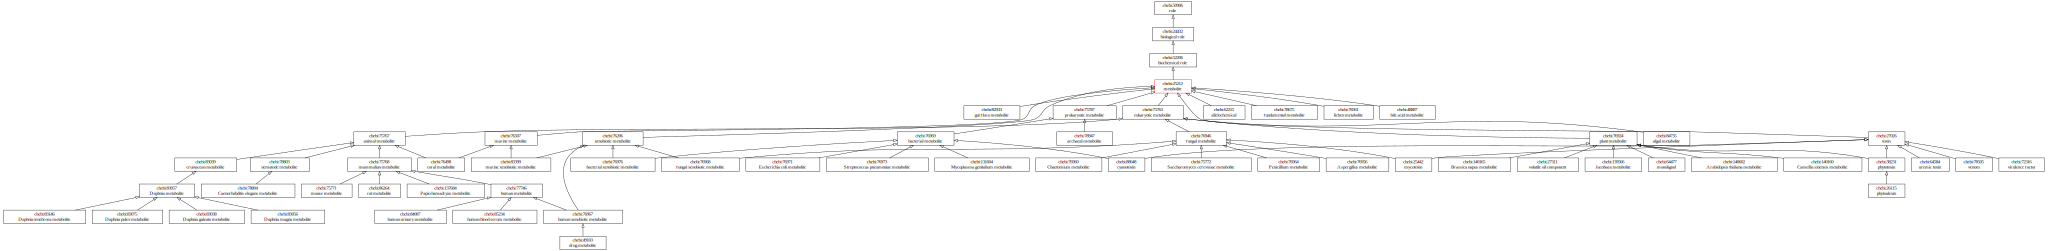

In [8]:
query="""
# hierarchy of the descendants of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleChild ?roleChildLabel
WHERE {
  VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?roleChild rdfs:subClassOf ?role .
  ?roleChild rdf:type owl:Class .
  ?roleChild rdfs:label ?roleChildLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["roleChild"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleChildLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")

query="""
# hierarchy of the ancestors of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleParent ?roleParentLabel
WHERE {
  VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  #?role rdfs:subClassOf* ?roleRoot .
  ?roleRoot rdfs:subClassOf* ?role .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf ?roleParent .
  ?roleParent rdf:type owl:Class .
  ?roleParent rdfs:label ?roleParentLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

#graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["roleParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleParentLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")
    
graph.node('chebi_25212', label="chebi:25212\nmetabolite", shape="box", color='red')
graph

In [12]:
graph.render(directory='figures', filename="chebi_metabolite_hierarchy", format='png')
pathlib.Path('figures/chebi_metabolite_hierarchy').unlink()

## 3.2 xenobiotic metabolite use case

In [12]:
query="""
# descendants of the "xenobiotic metabolite" role

SELECT DISTINCT ?role ?roleLabel 
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role                        roleLabel
0  http://purl.obolibrary.org/obo/CHEBI_76206            xenobiotic metabolite
1  http://purl.obolibrary.org/obo/CHEBI_76967      human xenobiotic metabolite
2  http://purl.obolibrary.org/obo/CHEBI_49103                  drug metabolite
3  http://purl.obolibrary.org/obo/CHEBI_76968     fungal xenobiotic metabolite
4  http://purl.obolibrary.org/obo/CHEBI_83399     marine xenobiotic metabolite
5  http://purl.obolibrary.org/obo/CHEBI_76976  bacterial xenobiotic metabolite

In [13]:
query="""
# hierarchy of the descendants of the "xenobiotic metabolite" role

SELECT DISTINCT ?role ?roleLabel ?roleChild ?roleChildLabel
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?roleChild rdfs:subClassOf ?role .
  ?roleChild rdf:type owl:Class .
  ?roleChild rdfs:label ?roleChildLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role                    roleLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite   
1  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite   
2  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite   
3  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite   
4  http://purl.obolibrary.org/obo/CHEBI_76967  human xenobiotic metabolite   

                                    roleChild                   roleChildLabel  
0  http://purl.obolibrary.org/obo/CHEBI_76967      human xenobiotic metabolite  
1  http://purl.obolibrary.org/obo/CHEBI_76968     fungal xenobiotic metabolite  
2  http://purl.obolibrary.org/obo/CHEBI_83399     marine xenobiotic metabolite  
3  http://purl.obolibrary.org/obo/CHEBI_76976  bacterial xenobiotic metabolite  
4  http://purl.obolibrary.org/obo/CHEBI_49103                  drug metabolite

![Descendants of xenobiotic metabolite](figures/chebi_role_xenobiotic_metabolite.png)

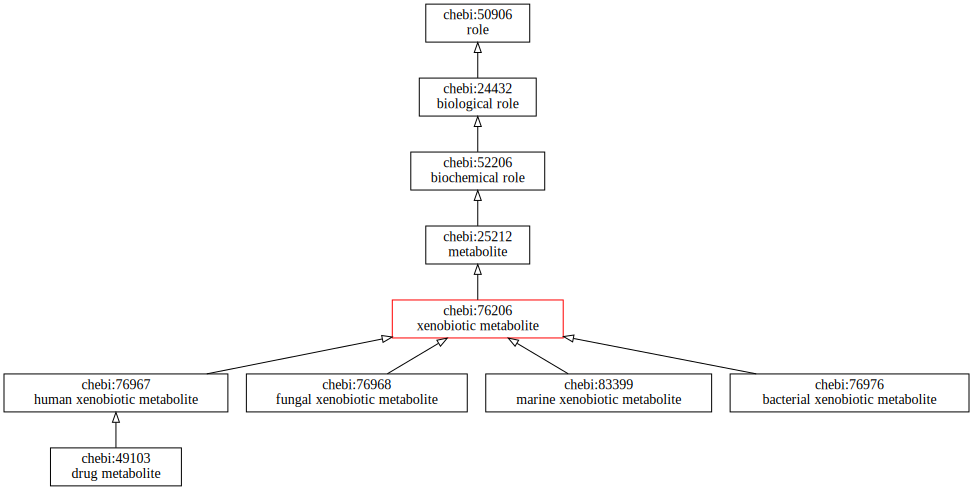

In [13]:
query="""
# hierarchy of the descendants of the "xenobiotic metabolite" role

SELECT DISTINCT ?role ?roleLabel ?roleChild ?roleChildLabel
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?roleChild rdfs:subClassOf ?role .
  ?roleChild rdf:type owl:Class .
  ?roleChild rdfs:label ?roleChildLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["roleChild"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleChildLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")

query="""
# hierarchy of the ancestors of the "xenobiotic metabolite" role

SELECT DISTINCT ?role ?roleLabel ?roleParent ?roleParentLabel
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  #?role rdfs:subClassOf* ?roleRoot .
  ?roleRoot rdfs:subClassOf* ?role .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf ?roleParent .
  ?roleParent rdf:type owl:Class .
  ?roleParent rdfs:label ?roleParentLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

#graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["roleParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleParentLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")
    
graph.node('chebi_76206', label="chebi:76206\nxenobiotic metabolite", shape="box", color='red')
graph

In [14]:
graph.render(directory='figures', filename="chebi_xenobiotic_metabolite_hierarchy", format='png')
pathlib.Path('figures/chebi_xenobiotic_metabolite_hierarchy').unlink()

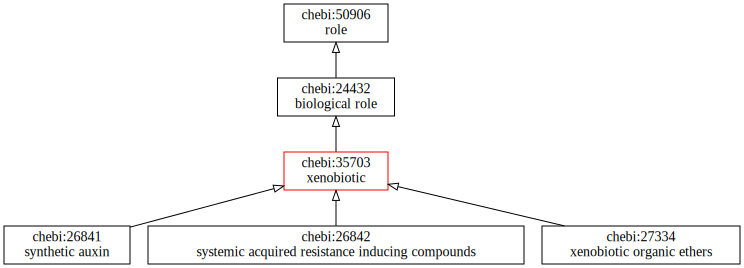

In [15]:
query="""
# hierarchy of the descendants of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleChild ?roleChildLabel
WHERE {
  VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?roleChild rdfs:subClassOf ?role .
  ?roleChild rdf:type owl:Class .
  ?roleChild rdfs:label ?roleChildLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["roleChild"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleChildLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")

query="""
# hierarchy of the ancestors of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleParent ?roleParentLabel
WHERE {
  VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  #?role rdfs:subClassOf* ?roleRoot .
  ?roleRoot rdfs:subClassOf* ?role .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf ?roleParent .
  ?roleParent rdf:type owl:Class .
  ?roleParent rdfs:label ?roleParentLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

#graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["roleParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleParentLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")
    
graph.node('chebi_35703', label="chebi:35703\nxenobiotic", shape="box", color='red')
graph

In [16]:
graph.render(directory='figures', filename="chebi_xenobiotic_hierarchy", format='png')
pathlib.Path('figures/chebi_xenobiotic_hierarchy').unlink()

## 3.3 number of molecules having (directly or indirectly) a role

> **Principle:** We have to consider both:
> - the hierarchy of molecules
> - the hierarchy of roles

In [16]:
query="""
# direct role(s) of a molecule

SELECT DISTINCT ?molecule ?moleculeLabel ?role ?roleLabel 
WHERE {
  VALUES ?molecule { chebidb:32635 } # paracetamol sulfate
  #VALUES ?molecule { chebidb:52476 } # sodium phenolate
  
  ?molecule rdfs:label ?moleculeLabel .
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule        moleculeLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   

                                         role        roleLabel  
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite

In [24]:
query="""
# indirect role(s) of a molecule

SELECT DISTINCT ?molecule ?moleculeLabel ?role ?roleLabel 
WHERE {
  VALUES ?molecule { chebidb:32635 }
  
  ?molecule rdfs:label ?moleculeLabel .
  ?molecule rdfs:subClassOf ?restriction .
  #?molecule rdfs:subClassOf+ ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule        moleculeLabel  \
0   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
1   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
2   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
3   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
4   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
5   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
6   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
7   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
8   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
9   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
10  http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   

                                          role                    roleLabel  
0   http://purl.obolibrary.org/obo/CHEBI_49103              drug metabolite  
1   http://purl.obolibrary.org/obo/CHEBI_76967  human xenobiotic metabolite  
2   http://purl.obolibrary.org/obo/CHEBI_77746             human metabolite  
3   http://purl.obolibrary.org/obo/CHEBI_75768         mammalian metabolite  
4   http://purl.obolibrary.org/obo/CHEBI_75767            animal metabolite  
5   http://purl.obolibrary.org/obo/CHEBI_75763        eukaryotic metabolite  
6   http://purl.obolibrary.org/obo/CHEBI_25212                   metabolite  
7   http://purl.obolibrary.org/obo/CHEBI_52206             biochemical role  
8   http://purl.obolibrary.org/obo/CHEBI_24432              biological role  
9   http://purl.obolibrary.org/obo/CHEBI_50906                         role  
10  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite

In [25]:
query="""
# direct role(s) of a molecule or its ancestors

SELECT DISTINCT ?molecule ?moleculeLabel ?role ?roleLabel 
WHERE {
  VALUES ?molecule { chebidb:32635 }
  
  ?molecule rdfs:label ?moleculeLabel .
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  ?restriction owl:someValuesFrom ?role .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule        moleculeLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   

                                         role        roleLabel  
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite

In [26]:
query="""
# indirect role(s) of a molecule or its ancestors

SELECT DISTINCT ?molecule ?moleculeLabel ?role ?roleLabel 
WHERE {
  VALUES ?molecule { chebidb:32635 }
  
  ?molecule rdfs:label ?moleculeLabel .
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule        moleculeLabel  \
0   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
1   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
2   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
3   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
4   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
5   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
6   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
7   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
8   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
9   http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   
10  http://purl.obolibrary.org/obo/CHEBI_32635  paracetamol sulfate   

                                          role                    roleLabel  
0   http://purl.obolibrary.org/obo/CHEBI_49103              drug metabolite  
1   http://purl.obolibrary.org/obo/CHEBI_76967  human xenobiotic metabolite  
2   http://purl.obolibrary.org/obo/CHEBI_77746             human metabolite  
3   http://purl.obolibrary.org/obo/CHEBI_75768         mammalian metabolite  
4   http://purl.obolibrary.org/obo/CHEBI_75767            animal metabolite  
5   http://purl.obolibrary.org/obo/CHEBI_75763        eukaryotic metabolite  
6   http://purl.obolibrary.org/obo/CHEBI_25212                   metabolite  
7   http://purl.obolibrary.org/obo/CHEBI_52206             biochemical role  
8   http://purl.obolibrary.org/obo/CHEBI_24432              biological role  
9   http://purl.obolibrary.org/obo/CHEBI_50906                         role  
10  http://purl.obolibrary.org/obo/CHEBI_76206        xenobiotic metabolite

In [30]:
query="""
# example of a molecule that is not directly a xenobiotic metabolite, 
# but is a descendant of a molecule that is a xenobiotic metabolite

SELECT DISTINCT ?molecule ?moleculeLabel ?superMolecule ?superMoleculeLabel ?role ?roleLabel 
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?molecule rdfs:label ?moleculeLabel .
  
  ?molecule rdfs:subClassOf+ ?superMolecule .
  ?superMolecule rdf:type owl:Class .
  ?superMolecule rdfs:label ?superMoleculeLabel .
  
  ?superMolecule rdfs:subClassOf ?restriction .
  #?superMolecule rdfs:subClassOf+ ?restriction .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf+ ?roleRoot .
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

> **Figure** ChEBI shows that sodium phenolate (`chebidb:52476`) has the direct role "disinfectant" (`chebidb:48219`), but also inherits the role "human xenobiotic metabolite" (`chebidb:76967`) from its superclass phenolate (`chebidb:50526`)
> ![sodium phenolate has the direct role "disinfectant", but also inherits the role "human xenobiotic metabolite" from its superclass phenolate](figures/chebi_molecule_sodium_phenolate.png)

> **Figure** sodium phenolate (`chebidb:52476`) has the direct role "disinfectant" (`chebidb:48219`), but also inherits the role "human xenobiotic metabolite" (`chebidb:76967`) from its superclass phenolate (`chebidb:50526`), and we can therefore infer that it has the more general role of "xenobiotic metabolism" (`chebidb:76206`).
> ![sodium phenolate has the direct role "disinfectant", but also inherits the role "human xenobiotic metabolite" from its superclass phenolate, and we can therefore infer that it has the more general role of "xenobiotic metabolism"](figures/chebi_role_sodium_phenolate.png)

> **Figure** sodium phenolate (`chebidb:52476`) has the direct role "disinfectant" (`chebidb:48219`), but also inherits the role "human xenobiotic metabolite" (`chebidb:76967`) from its superclass phenolate (`chebidb:50526`), and we can therefore infer that it has the more general role of "xenobiotic metabolism" (`chebidb:76206`).
> ![sodium phenolate has the direct role "disinfectant", but also inherits the role "human xenobiotic metabolite" from its superclass phenolate, and we can therefore infer that it has the more general role of "xenobiotic metabolism"](figures/chebi_role_sodium_phenolate_inherited.png)

In [17]:
query="""
# number of molecules having (directly or indirectly) a role
#
# encompasses
# - molecules that have a descendant of the role 
#   (e.g. all the molecules having the role "human xenobiotic metabolite" are also counted has having the role "xenobiotic metabolite")
# - molecules that are descendants of the molecule

SELECT DISTINCT ?role ?roleLabel (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
GROUP BY ?role ?roleLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role  \
0  http://purl.obolibrary.org/obo/CHEBI_76206   
1  http://purl.obolibrary.org/obo/CHEBI_76967   
2  http://purl.obolibrary.org/obo/CHEBI_49103   
3  http://purl.obolibrary.org/obo/CHEBI_76976   
4  http://purl.obolibrary.org/obo/CHEBI_83399   
5  http://purl.obolibrary.org/obo/CHEBI_76968   

                         roleLabel nbMolecules  
0            xenobiotic metabolite        1037  
1      human xenobiotic metabolite         712  
2                  drug metabolite         177  
3  bacterial xenobiotic metabolite         155  
4     marine xenobiotic metabolite         107  
5     fungal xenobiotic metabolite          22

In [8]:
query="""
# number of molecules having (directly or indirectly) a role
#
# encompasses
# - molecules that have a descendant of the role 
#   (e.g. all the molecules having the role "human xenobiotic metabolite" are also counted has having the role "xenobiotic metabolite")
# - molecules that are descendants of the molecule

SELECT DISTINCT ?role ?roleLabel (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule rdf:type owl:Class .  
}
GROUP BY ?role ?roleLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

role  \
0  http://purl.obolibrary.org/obo/CHEBI_76206   
1  http://purl.obolibrary.org/obo/CHEBI_76967   
2  http://purl.obolibrary.org/obo/CHEBI_49103   
3  http://purl.obolibrary.org/obo/CHEBI_76976   
4  http://purl.obolibrary.org/obo/CHEBI_83399   
5  http://purl.obolibrary.org/obo/CHEBI_76968   

                         roleLabel nbMolecules  
0            xenobiotic metabolite        1037  
1      human xenobiotic metabolite         712  
2                  drug metabolite         177  
3  bacterial xenobiotic metabolite         155  
4     marine xenobiotic metabolite         107  
5     fungal xenobiotic metabolite          22

> **Interpretation:** There are (~~936~~ when not considering the hierarchy of molecules) 1037 molecules having (directly of indirectly) a xenobiotic metabolite role

In [21]:
query="""
# number of molecules having (directly or indirectly) a role

SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  #?molecule rdfs:subClassOf ?restriction .
  ?molecule rdfs:subClassOf+ ?restriction .
  ?molecule rdf:type owl:Class .
  ?molecule rdfs:label ?moleculeLabel .
  ?restriction rdf:type owl:Restriction .
  ?restriction owl:onProperty obo:RO_0000087 .
  #?restriction owl:someValuesFrom ?role .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?role .
}
GROUP BY ?molecule ?moleculeLabel
ORDER BY DESC(?nbRoles)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule  \
0     http://purl.obolibrary.org/obo/CHEBI_133458   
1     http://purl.obolibrary.org/obo/CHEBI_133917   
2     http://purl.obolibrary.org/obo/CHEBI_136492   
3     http://purl.obolibrary.org/obo/CHEBI_140184   
4      http://purl.obolibrary.org/obo/CHEBI_16104   
...                                           ...   
1032   http://purl.obolibrary.org/obo/CHEBI_84054   
1033   http://purl.obolibrary.org/obo/CHEBI_85000   
1034   http://purl.obolibrary.org/obo/CHEBI_87752   
1035   http://purl.obolibrary.org/obo/CHEBI_90833   
1036    http://purl.obolibrary.org/obo/CHEBI_9666   

                                          moleculeLabel nbRoles  
0                             desmethylnaproxen sulfate       4  
1                                      ochratoxin alpha       4  
2               N-(2,6-diethylphenyl)-2-chloroacetamide       4  
3                                   hydroxyfenbendazole       4  
4                     3-(2-hydroxyphenyl)propanoic acid       4  
...                                                 ...     ...  
1032                  resveratrol glucuronide sulfate 2       1  
1033  1-octadecenoyl-2-icosatetraenoyl-sn-glycero-3-...       1  
1034                           benzo[a]pyrene-7,8-dione       1  
1035                              5-hydroperoxy-15-HETE       1  
1036                                        triadimenol       1  

[1037 rows x 3 columns]

In [10]:
query="""
# number of molecules having (directly or indirectly) a role

SELECT DISTINCT ?molecule ?moleculeLabel (COUNT(DISTINCT ?role) AS ?nbRoles)
WHERE {
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?molecule (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) ?role .
  ?molecule rdf:type owl:Class .
  ?molecule rdfs:label ?moleculeLabel .
}
GROUP BY ?molecule ?moleculeLabel
ORDER BY DESC(?nbRoles)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule  \
0     http://purl.obolibrary.org/obo/CHEBI_133458   
1     http://purl.obolibrary.org/obo/CHEBI_133917   
2     http://purl.obolibrary.org/obo/CHEBI_136492   
3     http://purl.obolibrary.org/obo/CHEBI_140184   
4      http://purl.obolibrary.org/obo/CHEBI_16104   
...                                           ...   
1032   http://purl.obolibrary.org/obo/CHEBI_84054   
1033   http://purl.obolibrary.org/obo/CHEBI_85000   
1034   http://purl.obolibrary.org/obo/CHEBI_87752   
1035   http://purl.obolibrary.org/obo/CHEBI_90833   
1036    http://purl.obolibrary.org/obo/CHEBI_9666   

                                          moleculeLabel nbRoles  
0                             desmethylnaproxen sulfate       4  
1                                      ochratoxin alpha       4  
2               N-(2,6-diethylphenyl)-2-chloroacetamide       4  
3                                   hydroxyfenbendazole       4  
4                     3-(2-hydroxyphenyl)propanoic acid       4  
...                                                 ...     ...  
1032                  resveratrol glucuronide sulfate 2       1  
1033  1-octadecenoyl-2-icosatetraenoyl-sn-glycero-3-...       1  
1034                           benzo[a]pyrene-7,8-dione       1  
1035                              5-hydroperoxy-15-HETE       1  
1036                                        triadimenol       1  

[1037 rows x 3 columns]

## 3.4 Functional parent(s) of a metabolite

In [39]:
query="""
# direct role(s) and functional parent(s) of a molecule

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
WHERE {
  VALUES ?moleculeMetabolite { chebidb:32635 } # paracetamol sulfate
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite moleculeMetaboliteLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   

                                         role        roleLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   

                     moleculeFunctionalParent moleculeFunctionalParentLabel  
0  http://purl.obolibrary.org/obo/CHEBI_46195                   paracetamol

In [41]:
query="""
# INdirect role(s) and functional parent(s) of a molecule
#
# both sulfuric acid and oxoacid are inherited from paracetamol sulfate superclasses

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
WHERE {
  VALUES ?moleculeMetabolite { chebidb:32635 } # paracetamol sulfate
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite moleculeMetaboliteLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   
1  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   
2  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   

                                         role        roleLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   
1  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   
2  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   

                     moleculeFunctionalParent moleculeFunctionalParentLabel  
0  http://purl.obolibrary.org/obo/CHEBI_26836                 sulfuric acid  
1  http://purl.obolibrary.org/obo/CHEBI_24833                       oxoacid  
2  http://purl.obolibrary.org/obo/CHEBI_46195                   paracetamol

In [26]:
query="""
# INdirect role(s) and functional parent(s) of a molecule
#
# both sulfuric acid and oxoacid are inherited from paracetamol sulfate superclasses

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
WHERE {
  VALUES ?moleculeMetabolite { chebidb:32635 } # paracetamol sulfate
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole ?role .
  ?role rdfs:label ?roleLabel .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite moleculeMetaboliteLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   
1  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   
2  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   

                                         role        roleLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   
1  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   
2  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   

                     moleculeFunctionalParent moleculeFunctionalParentLabel  
0  http://purl.obolibrary.org/obo/CHEBI_46195                   paracetamol  
1  http://purl.obolibrary.org/obo/CHEBI_26836                 sulfuric acid  
2  http://purl.obolibrary.org/obo/CHEBI_24833                       oxoacid

> **Figure** functional parents of paracetamol sulfate (`chebidb:32635`)
> ![functional parents of paracetamol sulfate](figures/chebi_paracetamol_functional_parent.png)

> **Figure** ChEBI screenshot showing the functional parents of paracetamol sulfate (`chebidb:32635`)
> ![ChEBI screenshot showing the functional parents of paracetamol sulfate](figures/chebi_functional_parents_paracetamol_sulfate.png)

In [42]:
query="""
# INdirect role(s) and functional parent(s) of a molecule
#
# both sulfuric acid and oxoacid are inherited from paracetamol sulfate superclasses

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?moleculeMetaboliteAncestor ?moleculeMetaboliteAncestorLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
WHERE {
  VALUES ?moleculeMetabolite { chebidb:32635 } # paracetamol sulfate
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?moleculeMetabolite rdfs:subClassOf+ ?moleculeMetaboliteAncestor .
  ?moleculeMetaboliteAncestor rdf:type owl:Class .
  ?moleculeMetaboliteAncestor rdfs:label ?moleculeMetaboliteAncestorLabel .
  
  ?moleculeMetaboliteAncestor rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite moleculeMetaboliteLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   
1  http://purl.obolibrary.org/obo/CHEBI_32635     paracetamol sulfate   

                   moleculeMetaboliteAncestor moleculeMetaboliteAncestorLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_37826        sulfuric acid derivative   
1  http://purl.obolibrary.org/obo/CHEBI_33241              oxoacid derivative   

                                         role        roleLabel  \
0  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   
1  http://purl.obolibrary.org/obo/CHEBI_49103  drug metabolite   

                     moleculeFunctionalParent moleculeFunctionalParentLabel  
0  http://purl.obolibrary.org/obo/CHEBI_26836                 sulfuric acid  
1  http://purl.obolibrary.org/obo/CHEBI_24833                       oxoacid

> **Interpretation:** some functional parents of paracetamol sulfate (`chebidb:32635`) are inherited from its superclasses

> **Figure** functional parents of paracetamol sulfate (`chebidb:32635`) are inherited from its superclasses
> ![functional parents of paracetamol sulfate](figures/chebi_paracetamol_functional_parent_hierarchy.png)

In [25]:
query="""
# molecules and their xenobiotic metabolite

#SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
SELECT DISTINCT (?moleculeFunctionalParent AS ?molecule) (?moleculeFunctionalParentLabel AS ?moleculeLabel) ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 } # paracetamol sulfate
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule  \
0    http://purl.obolibrary.org/obo/CHEBI_30746   
1     http://purl.obolibrary.org/obo/CHEBI_8459   
2    http://purl.obolibrary.org/obo/CHEBI_48467   
3    http://purl.obolibrary.org/obo/CHEBI_15891   
4    http://purl.obolibrary.org/obo/CHEBI_18072   
..                                          ...   
419  http://purl.obolibrary.org/obo/CHEBI_16891   
420  http://purl.obolibrary.org/obo/CHEBI_28125   
421  http://purl.obolibrary.org/obo/CHEBI_18012   
422   http://purl.obolibrary.org/obo/CHEBI_6931   
423  http://purl.obolibrary.org/obo/CHEBI_17347   

                                         moleculeLabel  \
0                                         benzoic acid   
1                                            promazine   
2    (25R)-3alpha,7alpha-dihydroxy-5beta-cholestan-...   
3                                              taurine   
4                                5-hydroxyisouric acid   
..                                                 ...   
419                                     glyoxylic acid   
420      all-cis-docosa-4,7,10,13,16,19-hexaenoic acid   
421                                       fumaric acid   
422                                          midazolam   
423                                       testosterone   

                              moleculeMetabolite  \
0    http://purl.obolibrary.org/obo/CHEBI_140241   
1    http://purl.obolibrary.org/obo/CHEBI_145225   
2    http://purl.obolibrary.org/obo/CHEBI_136361   
3    http://purl.obolibrary.org/obo/CHEBI_136361   
4     http://purl.obolibrary.org/obo/CHEBI_90885   
..                                           ...   
419   http://purl.obolibrary.org/obo/CHEBI_83716   
420  http://purl.obolibrary.org/obo/CHEBI_140196   
421  http://purl.obolibrary.org/obo/CHEBI_167450   
422  http://purl.obolibrary.org/obo/CHEBI_145331   
423   http://purl.obolibrary.org/obo/CHEBI_34749   

                               moleculeMetaboliteLabel  \
0                        3-bromo-4-hydroxybenzoic acid   
1                                  promazine sulfoxide   
2    (25R)-3alpha,7alpha-dihydroxy-5beta-cholestan-...   
3    (25R)-3alpha,7alpha-dihydroxy-5beta-cholestan-...   
4                1,3,7-trimethyl-5-hydroxyisouric acid   
..                                                 ...   
419                        2-aminophenylglyoxylic acid   
420  (7S,14S)-bis(hydroperoxy)-(4Z,8E,10Z,12E,16Z,1...   
421                                monomethyl fumarate   
422                                 4-hydroxymidazolam   
423                                        ethisterone   

                                           role  \
0    http://purl.obolibrary.org/obo/CHEBI_76976   
1    http://purl.obolibrary.org/obo/CHEBI_49103   
2    http://purl.obolibrary.org/obo/CHEBI_76967   
3    http://purl.obolibrary.org/obo/CHEBI_76967   
4    http://purl.obolibrary.org/obo/CHEBI_76976   
..                                          ...   
419  http://purl.obolibrary.org/obo/CHEBI_76976   
420  http://purl.obolibrary.org/obo/CHEBI_76967   
421  http://purl.obolibrary.org/obo/CHEBI_49103   
422  http://purl.obolibrary.org/obo/CHEBI_49103   
423  http://purl.obolibrary.org/obo/CHEBI_49103   

                           roleLabel  
0    bacterial xenobiotic metabolite  
1                    drug metabolite  
2        human xenobiotic metabolite  
3        human xenobiotic metabolite  
4    bacterial xenobiotic metabolite  
..                               ...  
419  bacterial xenobiotic metabolite  
420      human xenobiotic metabolite  
421                  drug metabolite  
422                  drug metabolite  
423                  drug metabolite  

[424 rows x 6 columns]

> **TODO:** distribution of the number of fonctional parents of a metabolite

In [27]:
query="""
# molecules and their xenobiotic metabolite

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbMolecules)
#SELECT DISTINCT (?moleculeFunctionalParent AS ?molecule) (?moleculeFunctionalParentLabel AS ?moleculeLabel) ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
GROUP BY ?moleculeMetabolite ?moleculeMetaboliteLabel
ORDER BY DESC(?nbMolecules)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0    http://purl.obolibrary.org/obo/CHEBI_134218   
1    http://purl.obolibrary.org/obo/CHEBI_136361   
2    http://purl.obolibrary.org/obo/CHEBI_136386   
3    http://purl.obolibrary.org/obo/CHEBI_136988   
4    http://purl.obolibrary.org/obo/CHEBI_136989   
..                                           ...   
358   http://purl.obolibrary.org/obo/CHEBI_90990   
359   http://purl.obolibrary.org/obo/CHEBI_90995   
360   http://purl.obolibrary.org/obo/CHEBI_91132   
361   http://purl.obolibrary.org/obo/CHEBI_91135   
362   http://purl.obolibrary.org/obo/CHEBI_91274   

                               moleculeMetaboliteLabel nbMolecules  
0    1-tetradecanoyl-2-icosanoyl-sn-glycero-3-phosp...           2  
1    (25R)-3alpha,7alpha-dihydroxy-5beta-cholestan-...           2  
2    1-icosanoyl-2-docosanoyl-sn-glycero-3-phospho-...           2  
3    N-[(8Z,11Z,14Z)-5,6-epoxyicosatrienoyl]ethanol...           2  
4    N-[(5Z,11Z,14Z)-8,9-epoxyicosatrienoyl]ethanol...           2  
..                                                 ...         ...  
358                                       12,20-DiHETE           1  
359                                        12(S)-HETrE           1  
360                                         18(R)-HETE           1  
361                         19-hydroxyprostaglandin H1           1  
362  (7Z,10Z,13R,14E,16Z,19Z)-13-hydroxydocosapenta...           1  

[363 rows x 3 columns]

> **TODO:** distribution of the number of metabolites of a functional parent

In [28]:
query="""
# molecules and their xenobiotic metabolite

SELECT DISTINCT (?moleculeFunctionalParent AS ?molecule) (?moleculeFunctionalParentLabel AS ?moleculeLabel) (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
}
GROUP BY ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
ORDER BY DESC(?nbMetabolites)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule  \
0    http://purl.obolibrary.org/obo/CHEBI_28125   
1    http://purl.obolibrary.org/obo/CHEBI_30746   
2    http://purl.obolibrary.org/obo/CHEBI_53488   
3    http://purl.obolibrary.org/obo/CHEBI_15366   
4    http://purl.obolibrary.org/obo/CHEBI_47381   
..                                          ...   
233  http://purl.obolibrary.org/obo/CHEBI_91133   
234   http://purl.obolibrary.org/obo/CHEBI_9330   
235   http://purl.obolibrary.org/obo/CHEBI_9332   
236   http://purl.obolibrary.org/obo/CHEBI_9555   
237   http://purl.obolibrary.org/obo/CHEBI_9588   

                                     moleculeLabel nbMetabolites  
0    all-cis-docosa-4,7,10,13,16,19-hexaenoic acid            14  
1                                     benzoic acid            11  
2       (7Z,10Z,13Z,16Z,19Z)-docosapentaenoic acid            11  
3                                      acetic acid             7  
4                                       diclofenac             7  
..                                             ...           ...  
233                               prostaglandin H1             1  
234                                  sulfamic acid             1  
235                               sulfamethoxazole             1  
236                                     tioguanine             1  
237                                    ticlopidine             1  

[238 rows x 3 columns]

> **TODO:** in ChEBI, 
> - are all the "xenobiotic metabolites" actually the metabolite of a molecule that has the role "xenobiotic"?
> - do all the metabolites of a (molecule that has the role) xenobiotic actually have the "xenobiotic metabolite" role?

![Descendants of xenobiotic metabolite](figures/chebi_role_xenobiotic_metabolite.png)

![Descendants of xenobiotic](figures/chebi_role_xenobiotic.png)

### 3.4.1 Dependency1: FIXME

### 3.4.2 Dependency2: Do all the molecules that have a "xenobiotic metabolite" role have at least 1 functional parent (i.e. are the metabolite of some molecule)?

In [17]:
query="""
# number of molecules with the metabolite role

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMoleculesMetaboliteRole)

WHERE {
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:25212 . # metabolite
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesMetaboliteRole
0                     24248

In [40]:
query="""
# number of molecules with the metabolite role

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMoleculesMetaboliteRole)

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:25212 . # metabolite
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesMetaboliteRole
0                     24248

In [18]:
query="""
# are there some metabolites that do not have a functional parent

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel #?role ?roleLabel 

WHERE {
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:25212 . # metabolite
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
    ?restrictionFunctional rdf:type owl:Restriction .
    ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
    #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
    #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0       http://purl.obolibrary.org/obo/CHEBI_87716   
1       http://purl.obolibrary.org/obo/CHEBI_32557   
2       http://purl.obolibrary.org/obo/CHEBI_35861   
3      http://purl.obolibrary.org/obo/CHEBI_137674   
4       http://purl.obolibrary.org/obo/CHEBI_77368   
...                                            ...   
10618   http://purl.obolibrary.org/obo/CHEBI_52367   
10619   http://purl.obolibrary.org/obo/CHEBI_17381   
10620   http://purl.obolibrary.org/obo/CHEBI_70266   
10621   http://purl.obolibrary.org/obo/CHEBI_17588   
10622   http://purl.obolibrary.org/obo/CHEBI_70335   

                                 moleculeMetaboliteLabel  
0                                   (-)-dihydroedulan II  
1                                         D-lysinium(1+)  
2                                     dibenzo[a,l]pyrene  
3                                           benzyl thiol  
4          (11Z,14Z,17Z,20Z,23Z)-hexacosapentaenoic acid  
...                                                  ...  
10618                                   1-naphthaldehyde  
10619                                    porphobilinogen  
10620                                 aglaiabbreviatin E  
10621                                     L-homocysteine  
10622  (22E,24R)-3beta,5alpha,9alpha-trihydroxyergost...  

[10623 rows x 2 columns]

In [11]:
query="""
# are there some metabolites that do not have a functional parent

#SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel #?role ?roleLabel 
SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMolecules)

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:25212 . # metabolite
  ?moleculeMetabolite rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeFunctionalParent .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMolecules
0       10623

In [19]:
query="""
# nb of molecules that have a functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMoleculesMetaboliteRole)

WHERE {
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesMetaboliteRole
0                     59964

In [12]:
query="""
# nb of molecules that have a functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMoleculesMetaboliteRole)

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeFunctionalParent .
  ?moleculeMetabolite rdf:type owl:Class .  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesMetaboliteRole
0                     59964

In [20]:
query="""
# molecules that have a functional parent but do not have the metabolite role

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel #?role ?roleLabel 

WHERE {
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  
  FILTER NOT EXISTS {
    #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
    ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
    ?restrictionRole rdf:type owl:Restriction .
    ?restrictionRole owl:onProperty obo:RO_0000087 .
    #?restrictionRole owl:someValuesFrom ?role .
    ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
    ?role rdfs:label ?roleLabel .
  
    ?role rdfs:subClassOf* chebidb:25212 . # metabolite
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0      http://purl.obolibrary.org/obo/CHEBI_192998   
1      http://purl.obolibrary.org/obo/CHEBI_157557   
2      http://purl.obolibrary.org/obo/CHEBI_122385   
3      http://purl.obolibrary.org/obo/CHEBI_137713   
4       http://purl.obolibrary.org/obo/CHEBI_62640   
...                                            ...   
46334   http://purl.obolibrary.org/obo/CHEBI_62130   
46335  http://purl.obolibrary.org/obo/CHEBI_139651   
46336  http://purl.obolibrary.org/obo/CHEBI_145620   
46337   http://purl.obolibrary.org/obo/CHEBI_85426   
46338   http://purl.obolibrary.org/obo/CHEBI_70991   

                                 moleculeMetaboliteLabel  
0                                             (E)-PYR-41  
1                        alpha-D-Galp-(1->2)-beta-D-Manp  
2      N-[(2S,3S,6R)-2-(hydroxymethyl)-6-[2-[(phenylm...  
3                          formyl 2E,4E,6Z-decatrienoate  
4      alpha-D-Kdo-(2->8)-alpha-D-Kdo-(2->4)-alpha-D-...  
...                                                  ...  
46334  beta-D-Galp-(1->4)-beta-D-GlcpNAc-(1->3)-beta-...  
46335                                        ascr#21-CoA  
46336  beta-D-GalpNAc-(1->4)-[alpha-Neup5Ac-(2->3)]-b...  
46337                              3-phenylpropionitrile  
46338    15-methylhexadecasphing-4-enine 1-phosphate(1-)  

[46339 rows x 2 columns]

In [13]:
query="""
# nb of molecules that have a functional parent but do not have the metabolite role

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMoleculesMetaboliteRole)

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeFunctionalParent .
  ?moleculeMetabolite rdf:type owl:Class . 
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:25212 . # metabolite
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculesMetaboliteRole
0                     46339

### 3.4.3 Dependency3: Are all the "xenobiotic metabolites" actually the metabolite of a molecule that has the role "xenobiotic"?

In [31]:
query="""
# are there some xenobiotic metabolites that do not have a functional parent

SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
    ?restrictionFunctional rdf:type owl:Restriction .
    ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
    #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
    
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0    http://purl.obolibrary.org/obo/CHEBI_132874   
1     http://purl.obolibrary.org/obo/CHEBI_47802   
2     http://purl.obolibrary.org/obo/CHEBI_83486   
3     http://purl.obolibrary.org/obo/CHEBI_83459   
4     http://purl.obolibrary.org/obo/CHEBI_81276   
..                                           ...   
608   http://purl.obolibrary.org/obo/CHEBI_83510   
609   http://purl.obolibrary.org/obo/CHEBI_87460   
610   http://purl.obolibrary.org/obo/CHEBI_30832   
611   http://purl.obolibrary.org/obo/CHEBI_83445   
612   http://purl.obolibrary.org/obo/CHEBI_15882   

                    moleculeMetaboliteLabel  \
0    mono[2-(carboxymethyl)hexyl] phthalate   
1                    5H-dibenzo[b,f]azepine   
2            2',2'-difluoro-2'-deoxyuridine   
3                  N(4)-acetylsulfathiazole   
4                      allodeoxycholic acid   
..                                      ...   
608                     ethofumesate-2-keto   
609              6-hydroxy-N-methylmyosmine   
610                             adipic acid   
611     2-isopropyl-6-methyl-4-pyrimidinone   
612                                  phenol   

                                           role  \
0    http://purl.obolibrary.org/obo/CHEBI_76967   
1    http://purl.obolibrary.org/obo/CHEBI_83399   
2    http://purl.obolibrary.org/obo/CHEBI_83399   
3    http://purl.obolibrary.org/obo/CHEBI_83399   
4    http://purl.obolibrary.org/obo/CHEBI_76206   
..                                          ...   
608  http://purl.obolibrary.org/obo/CHEBI_83399   
609  http://purl.obolibrary.org/obo/CHEBI_76976   
610  http://purl.obolibrary.org/obo/CHEBI_76967   
611  http://purl.obolibrary.org/obo/CHEBI_83399   
612  http://purl.obolibrary.org/obo/CHEBI_76967   

                           roleLabel  
0        human xenobiotic metabolite  
1       marine xenobiotic metabolite  
2       marine xenobiotic metabolite  
3       marine xenobiotic metabolite  
4              xenobiotic metabolite  
..                               ...  
608     marine xenobiotic metabolite  
609  bacterial xenobiotic metabolite  
610      human xenobiotic metabolite  
611     marine xenobiotic metabolite  
612      human xenobiotic metabolite  

[613 rows x 4 columns]

> **TODO:** consistency check
> - nb xenobiotic metabolites
> - nb xenobiotic metabolites with >=1 functional parent
> - nb xenobiotic metabolites without functional parent

In [21]:
query="""
# consistency check : nb of xenobiotic metabolites 

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0          1037

In [14]:
query="""
# consistency check : nb of xenobiotic metabolites 

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
  ?moleculeMetabolite rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0          1037

In [25]:
query="""
# consistency check : nb of xenobiotic metabolites having >=1 functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0           614

In [15]:
query="""
# consistency check : nb of xenobiotic metabolites having >=1 functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
  ?moleculeMetabolite rdf:type owl:Class .
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?functionalParent .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0           614

In [17]:
query="""
# consistency check : nb of xenobiotic metabolites that do not have >=1 functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
    ?restrictionFunctional rdf:type owl:Restriction .
    ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
    #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
    #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0           423

In [16]:
query="""
# consistency check : nb of xenobiotic metabolites that do not have >=1 functional parent

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
  ?moleculeMetabolite rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeFunctionalParent .
  }
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0           423

In [6]:
query="""
# consistency check : nb of xenobiotic metabolites having >=1 functional parent that is a xenobiotic

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  #?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  #?restrictionRole owl:someValuesFrom ?role .
  ?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf+ ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  #?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  ?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
  #?moleculeFunctionalParent rdfs:subClassOf ?restrictionRoleXenobiotic . 
  ?moleculeFunctionalParent rdfs:subClassOf+ ?restrictionRoleXenobiotic .
  ?restrictionRoleXenobiotic rdf:type owl:Restriction .
  ?restrictionRoleXenobiotic owl:onProperty obo:RO_0000087 .
  #?restrictionRoleXenobiotic owl:someValuesFrom ?roleXenobiotic .
  ?restrictionRoleXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  
  ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [18]:
query="""
# consistency check : nb of xenobiotic metabolites having >=1 functional parent that is a xenobiotic

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
  ?moleculeMetabolite rdf:type owl:Class .
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?functionalParent .
  ?functionalParent rdf:type owl:Class .
  ?functionalParent (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:35703 . # xenobiotic
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0            27

In [36]:
query="""
# consistency check : nb of xenobiotic metabolites having >=1 functional parent, but none of them is a xenobiotic

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbMetabolites) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctionalXenobiotic .
    ?restrictionFunctionalXenobiotic rdf:type owl:Restriction .
    ?restrictionFunctionalXenobiotic owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctionalXenobiotic owl:someValuesFrom ?moleculeFunctionalParentXenobiotic .
    #?restrictionFunctionalXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParentXenobiotic .
    
    ?moleculeFunctionalParentXenobiotic rdfs:subClassOf ?restrictionRoleXenobiotic . 
    #?moleculeFunctionalParentXenobiotic rdfs:subClassOf+ ?restrictionRoleXenobiotic .
    ?restrictionRoleXenobiotic rdf:type owl:Restriction .
    ?restrictionRoleXenobiotic owl:onProperty obo:RO_0000087 .
    ?restrictionRoleXenobiotic owl:someValuesFrom ?roleXenobiotic .
    #?restrictionRoleXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  
    ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  }
  
  
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMetabolites
0           336

In [39]:
query="""
# xenobiotic metabolites having >=1 functional parent, but none of them is a xenobiotic

#SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
#SELECT DISTINCT (?moleculeFunctionalParent AS ?molecule) (?moleculeFunctionalParentLabel AS ?moleculeLabel) ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel 
SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctionalXenobiotic .
    ?restrictionFunctionalXenobiotic rdf:type owl:Restriction .
    ?restrictionFunctionalXenobiotic owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctionalXenobiotic owl:someValuesFrom ?moleculeFunctionalParentXenobiotic .
    #?restrictionFunctionalXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParentXenobiotic .
    
    ?moleculeFunctionalParentXenobiotic rdfs:subClassOf ?restrictionRoleXenobiotic . 
    #?moleculeFunctionalParentXenobiotic rdfs:subClassOf+ ?restrictionRoleXenobiotic .
    ?restrictionRoleXenobiotic rdf:type owl:Restriction .
    ?restrictionRoleXenobiotic owl:onProperty obo:RO_0000087 .
    ?restrictionRoleXenobiotic owl:someValuesFrom ?roleXenobiotic .
    #?restrictionRoleXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  
    ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  } 
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0    http://purl.obolibrary.org/obo/CHEBI_140241   
1    http://purl.obolibrary.org/obo/CHEBI_145225   
2    http://purl.obolibrary.org/obo/CHEBI_136361   
3     http://purl.obolibrary.org/obo/CHEBI_90885   
4     http://purl.obolibrary.org/obo/CHEBI_86545   
..                                           ...   
331   http://purl.obolibrary.org/obo/CHEBI_83716   
332  http://purl.obolibrary.org/obo/CHEBI_140196   
333  http://purl.obolibrary.org/obo/CHEBI_167450   
334  http://purl.obolibrary.org/obo/CHEBI_145331   
335   http://purl.obolibrary.org/obo/CHEBI_34749   

                               moleculeMetaboliteLabel  
0                        3-bromo-4-hydroxybenzoic acid  
1                                  promazine sulfoxide  
2    (25R)-3alpha,7alpha-dihydroxy-5beta-cholestan-...  
3                1,3,7-trimethyl-5-hydroxyisouric acid  
4                                 2-phenylbutyric acid  
..                                                 ...  
331                        2-aminophenylglyoxylic acid  
332  (7S,14S)-bis(hydroperoxy)-(4Z,8E,10Z,12E,16Z,1...  
333                                monomethyl fumarate  
334                                 4-hydroxymidazolam  
335                                        ethisterone  

[336 rows x 2 columns]

In [40]:
query="""
# parents of the xenobiotic metabolites having >=1 functional parent, but none of them is a xenobiotic
# (these parents are candidates for being tagged as xenobiotic)

#SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel ?role ?roleLabel ?moleculeFunctionalParent ?moleculeFunctionalParentLabel
SELECT DISTINCT ?moleculeMetabolite ?moleculeMetaboliteLabel (?moleculeFunctionalParent AS ?candidateXenobiotic) (?moleculeFunctionalParentLabel AS ?candidateXenobioticLabel) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctionalXenobiotic .
    ?restrictionFunctionalXenobiotic rdf:type owl:Restriction .
    ?restrictionFunctionalXenobiotic owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctionalXenobiotic owl:someValuesFrom ?moleculeFunctionalParentXenobiotic .
    #?restrictionFunctionalXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParentXenobiotic .
    
    ?moleculeFunctionalParentXenobiotic rdfs:subClassOf ?restrictionRoleXenobiotic . 
    #?moleculeFunctionalParentXenobiotic rdfs:subClassOf+ ?restrictionRoleXenobiotic .
    ?restrictionRoleXenobiotic rdf:type owl:Restriction .
    ?restrictionRoleXenobiotic owl:onProperty obo:RO_0000087 .
    ?restrictionRoleXenobiotic owl:someValuesFrom ?roleXenobiotic .
    #?restrictionRoleXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  
    ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  } 
}
ORDER BY ?moleculeMetabolite
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

moleculeMetabolite  \
0    http://purl.obolibrary.org/obo/CHEBI_102485   
1    http://purl.obolibrary.org/obo/CHEBI_111521   
2    http://purl.obolibrary.org/obo/CHEBI_111544   
3    http://purl.obolibrary.org/obo/CHEBI_128754   
4    http://purl.obolibrary.org/obo/CHEBI_131431   
..                                           ...   
352   http://purl.obolibrary.org/obo/CHEBI_90990   
353   http://purl.obolibrary.org/obo/CHEBI_90995   
354   http://purl.obolibrary.org/obo/CHEBI_91132   
355   http://purl.obolibrary.org/obo/CHEBI_91135   
356   http://purl.obolibrary.org/obo/CHEBI_91274   

                               moleculeMetaboliteLabel  \
0                            5-carboxy-2'-deoxyuridine   
1                                            valienone   
2                                 2'-hydroxyrifampicin   
3                                         GDP-valienol   
4                     (3,5-dihydroxyphenyl)acetic acid   
..                                                 ...   
352                                       12,20-DiHETE   
353                                        12(S)-HETrE   
354                                         18(R)-HETE   
355                         19-hydroxyprostaglandin H1   
356  (7Z,10Z,13R,14E,16Z,19Z)-13-hydroxydocosapenta...   

                            candidateXenobiotic  \
0    http://purl.obolibrary.org/obo/CHEBI_17568   
1    http://purl.obolibrary.org/obo/CHEBI_29704   
2    http://purl.obolibrary.org/obo/CHEBI_28077   
3    http://purl.obolibrary.org/obo/CHEBI_17552   
4    http://purl.obolibrary.org/obo/CHEBI_30745   
..                                          ...   
352  http://purl.obolibrary.org/obo/CHEBI_84447   
353  http://purl.obolibrary.org/obo/CHEBI_53486   
354  http://purl.obolibrary.org/obo/CHEBI_15843   
355  http://purl.obolibrary.org/obo/CHEBI_91133   
356  http://purl.obolibrary.org/obo/CHEBI_53488   

                           candidateXenobioticLabel  
0                                            uracil  
1                                         valiolone  
2                                        rifampicin  
3                                               GDP  
4                                 phenylacetic acid  
..                                              ...  
352  (5Z,8Z,10E,14Z)-12-hydroxyicosatetraenoic acid  
353             all-cis-icosa-8,11,14-trienoic acid  
354                                arachidonic acid  
355                                prostaglandin H1  
356      (7Z,10Z,13Z,16Z,19Z)-docosapentaenoic acid  

[357 rows x 4 columns]

In [41]:
query="""
# parents of the xenobiotic metabolites having >=1 functional parent, but none of them is a xenobiotic
# (these parents are candidates for being tagged as xenobiotic)

SELECT (COUNT(DISTINCT ?moleculeFunctionalParent) AS ?nbCandidateXenobiotic) 

WHERE {
  #VALUES ?moleculeMetabolite { chebidb:32635 }
  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionRole .
  #?moleculeMetabolite rdfs:subClassOf+ ?restrictionRole .
  ?restrictionRole rdf:type owl:Restriction .
  ?restrictionRole owl:onProperty obo:RO_0000087 .
  ?restrictionRole owl:someValuesFrom ?role .
  #?restrictionRole owl:someValuesFrom/(rdfs:subClassOf*) ?role .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctional .
  ?restrictionFunctional rdf:type owl:Restriction .
  ?restrictionFunctional owl:onProperty chebirel:has_functional_parent .
  ?restrictionFunctional owl:someValuesFrom ?moleculeFunctionalParent .
  #?restriction owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParent .
  ?moleculeFunctionalParent rdfs:label ?moleculeFunctionalParentLabel .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite rdfs:subClassOf ?restrictionFunctionalXenobiotic .
    ?restrictionFunctionalXenobiotic rdf:type owl:Restriction .
    ?restrictionFunctionalXenobiotic owl:onProperty chebirel:has_functional_parent .
    ?restrictionFunctionalXenobiotic owl:someValuesFrom ?moleculeFunctionalParentXenobiotic .
    #?restrictionFunctionalXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeFunctionalParentXenobiotic .
    
    ?moleculeFunctionalParentXenobiotic rdfs:subClassOf ?restrictionRoleXenobiotic . 
    #?moleculeFunctionalParentXenobiotic rdfs:subClassOf+ ?restrictionRoleXenobiotic .
    ?restrictionRoleXenobiotic rdf:type owl:Restriction .
    ?restrictionRoleXenobiotic owl:onProperty obo:RO_0000087 .
    ?restrictionRoleXenobiotic owl:someValuesFrom ?roleXenobiotic .
    #?restrictionRoleXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  
    ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  } 
}
ORDER BY ?moleculeMetabolite
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbCandidateXenobiotic
0                   224

### 3.4.4 Dependency4: do all the metabolites of a (molecule that has the role) xenobiotic actually have the "xenobiotic metabolite" role?

In [8]:
query="""
# molecules that have the role xenobiotic

SELECT (COUNT(DISTINCT ?moleculeXenobiotic) AS ?nbMoleculeXenobiotic) 

WHERE {  
  ?moleculeXenobiotic rdfs:label ?moleculeXenobioticLabel .
  
  #?moleculeXenobiotic rdfs:subClassOf ?restrictionXenobiotic .
  ?moleculeXenobiotic rdfs:subClassOf+ ?restrictionXenobiotic .
  ?restrictionXenobiotic rdf:type owl:Restriction .
  ?restrictionXenobiotic owl:onProperty obo:RO_0000087 .
  #?restrictionXenobiotic owl:someValuesFrom ?roleXenobiotic .
  ?restrictionXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  ?roleXenobiotic rdfs:label ?roleXenobioticLabel .
  
  ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculeXenobiotic
0                  667

In [19]:
query="""
# molecules that have the role xenobiotic

SELECT (COUNT(DISTINCT ?moleculeXenobiotic) AS ?nbMoleculeXenobiotic) 

WHERE {  
  ?moleculeXenobiotic (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:35703 . # xenobiotic
  ?moleculeXenobiotic rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbMoleculeXenobiotic
0                  667

In [46]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbmoleculeMetabolite) 

WHERE {  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionMetabolite .
  ?restrictionMetabolite rdf:type owl:Restriction .
  ?restrictionMetabolite owl:onProperty chebirel:has_functional_parent .
  ?restrictionMetabolite owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeXenobiotic .
  
  ?moleculeXenobiotic rdfs:subClassOf ?restrictionXenobiotic .
  #?moleculeXenobiotic rdfs:subClassOf+ ?restrictionXenobiotic .
  ?restrictionXenobiotic rdf:type owl:Restriction .
  ?restrictionXenobiotic owl:onProperty obo:RO_0000087 .
  ?restrictionXenobiotic owl:someValuesFrom ?roleXenobiotic .
  #?restrictionXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  ?roleXenobiotic rdfs:label ?roleXenobioticLabel .
  
  ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbmoleculeMetabolite
0                  147

In [20]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbmoleculeMetabolite) 

WHERE {  
  ?moleculeXenobiotic (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:35703 . # xenobiotic
  ?moleculeXenobiotic rdf:type owl:Class .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeXenobiotic .
  ?moleculeMetabolite rdf:type owl:Class .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbmoleculeMetabolite
0                  174

In [9]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic and have the xenobiotic metabolite role

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbmoleculeMetabolite) 

WHERE {  
  ?moleculeXenobiotic (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:35703 . # xenobiotic
  ?moleculeXenobiotic rdf:type owl:Class .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeXenobiotic .
  ?moleculeMetabolite rdf:type owl:Class .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbmoleculeMetabolite
0                   27

> **TODO: CONTINUE FROM HERE**

In [8]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic and do not have the xenobiotic metabolite role

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbmoleculeMetabolite) 

WHERE {  
  ?moleculeXenobiotic (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:35703 . # xenobiotic
  ?moleculeXenobiotic rdf:type owl:Class .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent/(rdfs:subClassOf*) ?moleculeXenobiotic .
  ?moleculeMetabolite rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?moleculeMetabolite (rdfs:subClassOf*)/od:hasRole/(rdfs:subClassOf*) chebidb:76206 . # xenobiotic metabolite
  }
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbmoleculeMetabolite
0                  147

In [47]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic, and themselves have the role xenobiotic metabolite

SELECT (COUNT(DISTINCT ?moleculeMetabolite) AS ?nbmoleculeMetabolite) 

WHERE {  
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionXenobioticMetabolite .
  ?restrictionXenobioticMetabolite rdf:type owl:Restriction .
  ?restrictionXenobioticMetabolite owl:onProperty obo:RO_0000087 .
  #?restrictionXenobioticMetabolite owl:someValuesFrom ?roleXenobioticMetabolite .
  ?restrictionXenobioticMetabolite owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobioticMetabolite .
  ?roleXenobioticMetabolite rdfs:label ?roleXenobioticMetaboliteLabel .
  
  ?roleXenobioticMetabolite rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  
  ?moleculeMetabolite rdfs:subClassOf ?restrictionMetabolite .
  ?restrictionMetabolite rdf:type owl:Restriction .
  ?restrictionMetabolite owl:onProperty chebirel:has_functional_parent .
  ?restrictionMetabolite owl:someValuesFrom/(rdfs:subClassOf*) ?moleculeXenobiotic .
  
  ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
  
  ?moleculeXenobiotic rdfs:subClassOf ?restrictionXenobiotic .
  #?moleculeXenobiotic rdfs:subClassOf+ ?restrictionXenobiotic .
  ?restrictionXenobiotic rdf:type owl:Restriction .
  ?restrictionXenobiotic owl:onProperty obo:RO_0000087 .
  ?restrictionXenobiotic owl:someValuesFrom ?roleXenobiotic .
  #?restrictionXenobiotic owl:someValuesFrom/(rdfs:subClassOf*) ?roleXenobiotic .
  ?roleXenobiotic rdfs:label ?roleXenobioticLabel .
  
  ?roleXenobiotic rdfs:subClassOf* chebidb:35703 . # xenobiotic
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

nbmoleculeMetabolite
0                   27

## 3.5 Transitivity

> **TODO:** are there metabolites of metabolites? (e.g. "paracetamol sulfate" is a metabolite of "paracetamol"; are the molecules that are metabolites of "paracetamol sulfate" (and therefore metabolites of metabolites of paracetamol)?

> **Figure** functional parents of paracetamol sulfate (`chebidb:32635`)
> ![functional parents of paracetamol sulfate](figures/chebi_paracetamol_functional_parent.png)

> **Figure** ChEBI screenshot showing the functional parents of paracetamol sulfate (`chebidb:32635`)
> ![ChEBI screenshot showing the functional parents of paracetamol sulfate](figures/chebi_functional_parents_paracetamol_sulfate.png)

In [15]:
query="""
# graph of direct and indirect metabolites of paracetamol

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                (?moleculeMetaboliteID AS ?metaboliteID)
                (?moleculeMetaboliteLabel AS ?metaboliteLabel)

WHERE {  
  VALUES ?moleculeOrig { chebidb:46195 } #paracetamol
  #VALUES ?moleculeOrig { chebidb:32635 } #paracetamol sulfate
  ?molecule ((rdfs:subClassOf*)/od:hasFunctionalParent)* ?moleculeOrig .
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  
  ?moleculeMetabolite (rdfs:subClassOf*)/od:hasFunctionalParent ?molecule .
  #?molecule (rdfs:subClassOf*)/od:hasFunctionalParent ?moleculeMetabolite .
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  ?moleculeMetabolite oboInOwl:id ?moleculeMetaboliteID .
}
ORDER BY ?moleculeID ?metaboliteID
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

metaboliteGraph = nx.DiGraph()

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    currentMolecule = result["moleculeID"]["value"].replace("CHEBI:", "chebi:")
    currentMetabolite = result["metaboliteID"]["value"].replace("CHEBI:", "chebi:")
    print("{}\t{}".format(result["moleculeLabel"]["value"], result["metaboliteLabel"]["value"]))
    metaboliteGraph.add_node(currentMolecule, label=result["moleculeLabel"]["value"])
    metaboliteGraph.add_node(currentMetabolite, label=result["metaboliteLabel"]["value"])
    metaboliteGraph.add_edge(currentMolecule, currentMetabolite)
    
nx.write_gexf(metaboliteGraph, "results/chebi-v{}-graphMetabolites-paracetamol.gexf".format(chebiVersion), encoding='utf-8', prettyprint=True, version='1.2draft')

paracetamol sulfate	4-(acetylamino)-3-hydroxyphenyl hydrogen sulfate
paracetamol sulfate	2-methoxyacetaminophen sulfate
paracetamol	2-methoxyacetaminophen glucuronide
paracetamol	S-(5-acetamido-2-hydroxyphenyl)cysteine
paracetamol	S-(5-acetamido-2-hydroxyphenyl)-N-acetyl-L-cysteine
paracetamol	methacetin
paracetamol	3-nitroacetaminophen
paracetamol	3-nitroacetaminophen-TMS
paracetamol	paracetamol sulfate
paracetamol	acetaminophen O-beta-D-glucosiduronic acid
paracetamol	acetaminophen glutathione conjugate
paracetamol	phenacetin


![Direct and indirect metyabolites of paracetamol](figures/chebi_paracetamol_metabolites_direct-indirect.png)

# 4. Lists of molecules

In [27]:
query="""
# molecules that are metabolites of a molecule that has the role xenobiotic, and themselves have the role xenobiotic metabolite

SELECT DISTINCT ?rel

WHERE {  
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  ?molecule rdf:type owl:Class .
  ?molecule ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [28]:
query="""
SELECT DISTINCT ?rel ?val
WHERE {
  VALUES ?molecule { chebidb:46195 } #paracetamol
  
  ?molecule ?rel ?val .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

In [22]:
query="""
# molecules and their characteristics

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                (REPLACE(STR(?moleculeStars), "http://purl.obolibrary.org/obo/chebi#", "") AS ?moleculeNbStars) 
                ?inchikey
                ?inchi
                ?smiles

WHERE {  
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  ?molecule oboInOwl:inSubset ?moleculeStars .
  ?molecule chebi:inchi ?inchi .
  ?molecule chebi:inchikey ?inchikey .
  ?molecule chebi:smiles ?smiles .
}
ORDER BY ?molecule
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-chemicalEntity-description.tsv".format(chebiVersion), sep="\t", index=False)

In [34]:
query="""
# molecules and their roles

SELECT DISTINCT ?moleculeID 
                (REPLACE(STR(?moleculeRole), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?role) 
                (?moleculeRoleLabel AS ?roleLabel)

WHERE {  
  #VALUES ?molecule{ chebidb:52476 } # sodium phenolate
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  
  ?molecule (rdfs:subClassOf*)/od:hasRole ?moleculeRole .
  ?moleculeRole rdfs:label ?moleculeRoleLabel .
}
ORDER BY ?molecule ?role
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-chemicalEntity-role.tsv".format(chebiVersion), sep="\t", index=False)

In [9]:
query="""
# molecules and their metabolites

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                (REPLACE(STR(?moleculeMetabolite), "http://purl.obolibrary.org/obo/CHEBI_", "CHEBI:") AS ?metabolite) 
                (?moleculeMetaboliteLabel AS ?metaboliteLabel)

WHERE {  
  ?directMetabolite od:hasFunctionalParent ?directMolecule .
  
  ?moleculeMetabolite rdfs:subClassOf* ?directMetabolite .
  ?moleculeMetabolite rdf:type owl:Class .
  ?moleculeMetabolite rdfs:label ?moleculeMetaboliteLabel .
  
  ?directMolecule rdfs:subClassOf* ?molecule .
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  
}
ORDER BY ?molecule ?metabolite
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-chemicalEntity-metabolite.tsv.zip".format(chebiVersion), sep="\t", index=False)

#sparql = SPARQLWrapper(endpointURL)
#sparql.setQuery(prefixes+query+"\nLIMIT 10")
#sparql.setReturnFormat(JSON)
#results = sparql.query().convert()
##for result in results["results"]["bindings"]:
##    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
#displaySparqlResults(results)



## Xenobiotic metabolites

In [11]:
query="""
# xenobiotic metabolites and their characteristics

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                (REPLACE(STR(?moleculeStars), "http://purl.obolibrary.org/obo/chebi#", "") AS ?moleculeNbStars) 
                ?inchikey
                ?inchi
                ?smiles

WHERE {  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  ?role rdf:type owl:Class .
  ?moleculeDirect od:hasRole ?role.

  ?molecule rdfs:subClassOf* ?moleculeDirect .
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  ?molecule oboInOwl:inSubset ?moleculeStars .
  ?molecule chebi:inchi ?inchi .
  ?molecule chebi:inchikey ?inchikey .
  ?molecule chebi:smiles ?smiles .
}
ORDER BY ?molecule
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-xenobioticMetabolites-description.tsv".format(chebiVersion), sep="\t", index=False)

In [13]:
query="""
# xenobiotic metabolites and their functional parents

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                ?parentID
                ?parentLabel

WHERE {  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  ?role rdf:type owl:Class .
  ?moleculeDirect od:hasRole ?role.

  ?molecule rdfs:subClassOf* ?moleculeDirect .
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  
  ?molecule od:hasFunctionalParent ?parent .
  ?parent rdf:type owl:Class .
  ?parent oboInOwl:id ?parentID .
  ?parent rdfs:label ?parentLabel .
}
ORDER BY ?moleculeID ?parentID
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-xenobioticMetabolites-functionalParents-direct.tsv".format(chebiVersion), sep="\t", index=False)

In [14]:
query="""
# xenobiotic metabolites and their functional parents

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                ?parentID
                ?parentLabel

WHERE {  
  ?role rdfs:subClassOf* chebidb:76206 . # xenobiotic metabolite
  ?role rdf:type owl:Class .
  ?moleculeDirect od:hasRole ?role.

  ?molecule rdfs:subClassOf* ?moleculeDirect .
  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  
  ?molecule od:hasFunctionalParent+ ?parent .
  ?parent rdf:type owl:Class .
  ?parent oboInOwl:id ?parentID .
  ?parent rdfs:label ?parentLabel .
}
ORDER BY ?moleculeID ?parentID
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

df = sparqldataframe.query(endpointURL, prefixes+query)
df.to_csv("results/chebi-v{}-xenobioticMetabolites-functionalParents-transitive.tsv".format(chebiVersion), sep="\t", index=False)

# Generalization

In [12]:
query="""
# generalization pattern1: generalize molecules

SELECT DISTINCT ?moleculeID 
                ?moleculeLabel 
                ?roleID
                ?roleLabel

WHERE {  
  #VALUES ?molecule { chebidb:17234 } # glucose
  #VALUES ?molecule { chebidb:46195 } # paracetamol
  
  ?moleculeX rdfs:subClassOf ?molecule .
  ?moleculeX (rdfs:subClassOf*)/od:hasRole ?role .
  
  FILTER NOT EXISTS {
    ?molecule (rdfs:subClassOf*)/od:hasRole ?role .
  }
  
  FILTER NOT EXISTS {
    ?moleculeY rdfs:subClassOf+ ?molecule .
    ?molecule rdf:type owl:Class .
    FILTER NOT EXISTS {
      ?moleculeY (rdfs:subClassOf*)/od:hasRole ?role .
    }
  }

  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:id ?moleculeID .
  ?molecule rdfs:label ?moleculeLabel .
  
  ?role oboInOwl:id ?roleID .
  ?role rdfs:label ?roleLabel .
}
ORDER BY ?moleculeID ?roleID
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query+"\nLIMIT 10")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#for result in results["results"]["bindings"]:
#    print("{}\t{}".format(result["property"]["value"], result["propertyLabel"]["value"]))
displaySparqlResults(results)

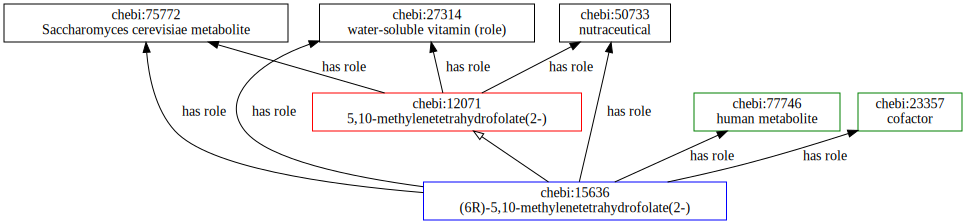

In [222]:
testGraph = getDescendantsGraph("chebidb:12071", highlightNodeColor="red", transitive=True)
getRoleGraph("chebidb:12071", graph=testGraph, inferredMolecule=True)
getRoleGraph("chebidb:15636", graph=testGraph, inferredMolecule=True)
highlightNode("chebidb:15636", highlightNodeColor="blue", graph=testGraph)
highlightNode("chebidb:77746", highlightNodeColor="green", graph=testGraph)
highlightNode("chebidb:23357", highlightNodeColor="green", graph=testGraph)

testGraph

# ChEBI visualization

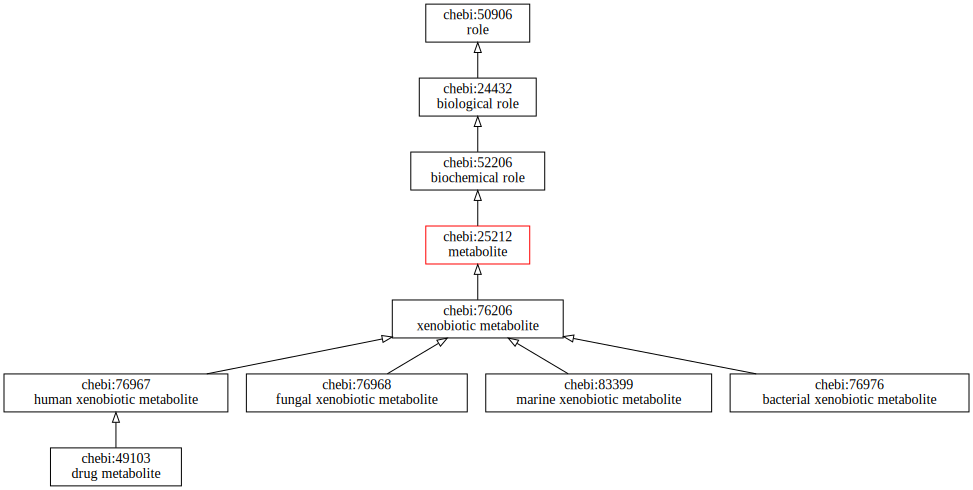

In [7]:
query="""
# hierarchy of the descendants of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleChild ?roleChildLabel
WHERE {
  #VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  ?role rdfs:subClassOf* ?roleRoot .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?roleChild rdfs:subClassOf ?role .
  ?roleChild rdf:type owl:Class .
  ?roleChild rdfs:label ?roleChildLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["roleChild"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleChildLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")

query="""
# hierarchy of the ancestors of the "xenobiotic" role

SELECT DISTINCT ?role ?roleLabel ?roleParent ?roleParentLabel
WHERE {
  #VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  
  #?role rdfs:subClassOf* ?roleRoot .
  ?roleRoot rdfs:subClassOf* ?role .
  ?role rdf:type owl:Class .
  ?role rdfs:label ?roleLabel .
  
  ?role rdfs:subClassOf ?roleParent .
  ?roleParent rdf:type owl:Class .
  ?roleParent rdfs:label ?roleParentLabel .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

#graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
#graph = graphviz.Digraph(graph_attr={'rankdir': 'RL'})
for result in results["results"]["bindings"]:
    parentIdent = result["roleParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    childIdent = result["role"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
    graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["roleParentLabel"]["value"]), shape="box")
    graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
    graph.edge(childIdent, parentIdent, arrowhead="empty")
    
graph.node('chebi_25212', label="chebi:25212\nmetabolite", shape="box", color='red')
graph

In [8]:
def highlightNode(nodeID, highlightNodeColor='red', graph=None):
    if graph is None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
        
    query="""
# node and label

SELECT DISTINCT ?nodeIdent ?nodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
}
"""
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box", color=highlightNodeColor)
    
    return graph

            

In [9]:
def getAncestorsGraph(nodeID, highlightNodeColor=None, graph=None, transitive=True):
    if graph is None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
    query="""
# hierarchy of the ancestors

SELECT DISTINCT ?nodeAncestor ?nodeAncestorLabel ?nodeAncestorParent ?nodeAncestorParentLabel
WHERE {
  #VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:subClassOf* ?nodeAncestor .
  
  ?nodeAncestor rdf:type owl:Class .
  ?nodeAncestor rdfs:label ?nodeAncestorLabel .
  
  ?nodeAncestor rdfs:subClassOf ?nodeAncestorParent .
  
  ?nodeAncestorParent rdf:type owl:Class .
  ?nodeAncestorParent rdfs:label ?nodeAncestorParentLabel .
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        parentIdent = result["nodeAncestorParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        childIdent = result["nodeAncestor"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["nodeAncestorParentLabel"]["value"]), shape="box")
        graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["nodeAncestorLabel"]["value"]), shape="box")
        graph.edge(childIdent, parentIdent, arrowhead="empty")
        
    if highlightNodeColor is not None:
        query="""
# node and label

SELECT DISTINCT ?nodeIdent ?nodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
}
"""
        sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
            graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box", color=highlightNodeColor)
    
    return graph

            

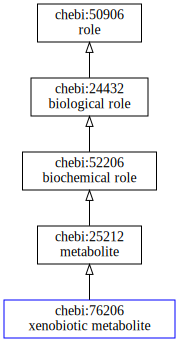

In [10]:
getAncestorsGraph("chebidb:76206", highlightNodeColor="blue")

In [11]:
def getDescendantsGraph(nodeID, highlightNodeColor=None, graph=None, transitive=True):
    if graph is None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
    query="""
# hierarchy of the descendants

SELECT DISTINCT ?nodeDescendant ?nodeDescendantLabel ?nodeDescendantParent ?nodeDescendantParentLabel
WHERE {
  #VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:subClassOf* ?nodeAncestor .
  ?nodeDescendantParent rdfs:subClassOf* ?nodeIdent .
  ?nodeDescendantParent rdf:type owl:Class .
  ?nodeDescendantParent rdfs:label ?nodeDescendantParentLabel .
  
  ?nodeDescendant rdfs:subClassOf ?nodeDescendantParent .
  
  ?nodeDescendant rdf:type owl:Class .
  ?nodeDescendant rdfs:label ?nodeDescendantLabel .
  
  
  
  
}
"""
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        parentIdent = result["nodeDescendantParent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        childIdent = result["nodeDescendant"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.node(parentIdent, label="{}\n{}".format(parentIdent.replace("chebi_", "chebi:"), result["nodeDescendantParentLabel"]["value"]), shape="box")
        graph.node(childIdent, label="{}\n{}".format(childIdent.replace("chebi_", "chebi:"), result["nodeDescendantLabel"]["value"]), shape="box")
        graph.edge(childIdent, parentIdent, arrowhead="empty")
        
    if highlightNodeColor is not None:
        query="""
# node and label

SELECT DISTINCT ?nodeIdent ?nodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
}
"""
        sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
            graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box", color=highlightNodeColor)
    
    return graph

            

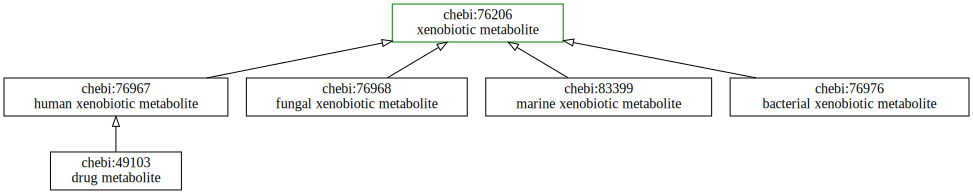

In [12]:
getDescendantsGraph("chebidb:76206", highlightNodeColor="green")

In [13]:
def getRoleGraph(nodeID, highlightNodeColor=None, graph=None, inferredMolecule=False, inferredRole=False):
    if graph is None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    query="""
# hierarchy of the descendants

SELECT DISTINCT ?nodeIdent ?nodeLabel ?roleIdent ?roleLabel
WHERE {
  #VALUES ?roleRoot { chebidb:25212 } # metabolite
  #VALUES ?roleRoot { chebidb:35703 } # xenobiotic
  #VALUES ?roleRoot { chebidb:76206 } # xenobiotic metabolite
  #VALUES ?roleRoot { chebidb:76967 } # human xenobiotic metabolite
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
  
  ?nodeIdent $rolePrefix$od:hasRole$roleSuffix$ ?roleIdent .
  ?roleIdent rdf:type owl:Class .
  ?roleIdent rdfs:label ?roleLabel .
}
"""
    query = query.replace('$rolePrefix$', '(rdfs:subClassOf*)/' if inferredMolecule else '')
    query = query.replace('$roleSuffix$', '/(rdfs:subClassOf*)' if inferredRole else '')
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        roleIdent = result["roleIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box")
        graph.node(roleIdent, label="{}\n{}".format(roleIdent.replace("chebi_", "chebi:"), result["roleLabel"]["value"]), shape="box")
        #graph.edge(nodeIdent, roleIdent, arrowhead="empty")
        graph.edge(nodeIdent, roleIdent, label="has role")
    
    # Hierarchy of roles
    query = """
# hierarchy of roles

SELECT DISTINCT ?roleIdent ?roleLabel ?roleAncestorIdent ?roleAncestorLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent $rolePrefix$od:hasRole$roleSuffix$ ?roleIdent .
  ?roleIdent rdf:type owl:Class .
  ?roleIdent rdfs:label ?roleLabel .
  
  ?roleIdent rdfs:subClassOf+ ?roleAncestorIdent .
  ?nodeIdent $rolePrefix$od:hasRole$roleSuffix$ ?roleAncestorIdent .
  ?roleAncestorIdent rdf:type owl:Class .
  ?roleAncestorIdent rdfs:label ?roleAncestorLabel .
  
  FILTER NOT EXISTS {
    ?roleIdent rdfs:subClassOf+ ?roleAncestorIntermediateIdent .
    ?roleAncestorIntermediateIdent rdfs:subClassOf+ ?roleAncestorIdent .
    ?nodeIdent $rolePrefix$od:hasRole$roleSuffix$ ?roleAncestorIntermediateIdent .
  }
  
}
"""
    query = query.replace('$rolePrefix$', '(rdfs:subClassOf*)/' if inferredMolecule else '')
    query = query.replace('$roleSuffix$', '/(rdfs:subClassOf*)' if inferredRole else '')
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        roleIdent = result["roleIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        roleParentIdent = result["roleAncestorIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.edge(roleIdent, roleParentIdent, arrowhead="empty")
        
    
    if highlightNodeColor is not None:
        query="""
# node and label

SELECT DISTINCT ?nodeIdent ?nodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
}
"""
        sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
            graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box", color=highlightNodeColor)
    
    return graph

            

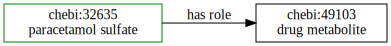

In [14]:
getRoleGraph("chebidb:32635", highlightNodeColor="green")

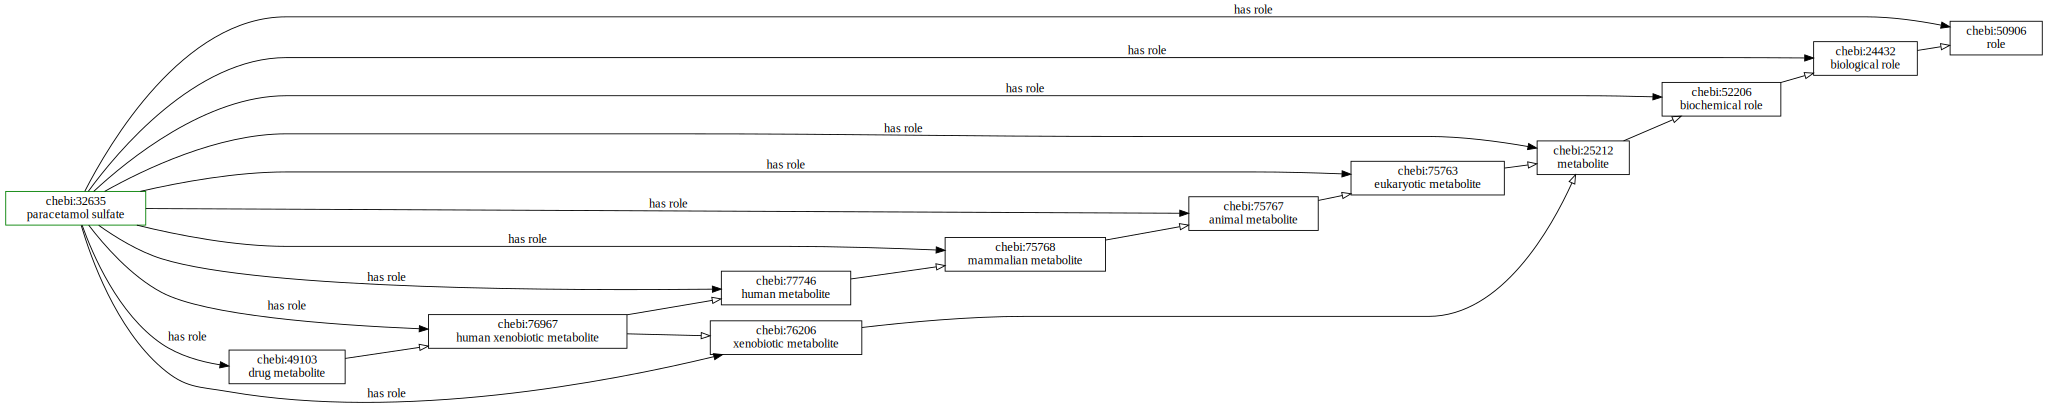

In [15]:
getRoleGraph("chebidb:32635", highlightNodeColor="green", inferredRole=True)

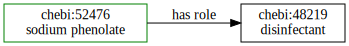

In [16]:
getRoleGraph("chebidb:52476", highlightNodeColor="green")

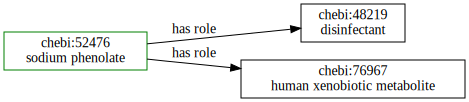

In [17]:
getRoleGraph("chebidb:52476", highlightNodeColor="green", inferredMolecule=True)

In [29]:
def getMetaboliteGraph(nodeID, highlightNodeColor=None, graph=None, direction='toMetabolite', transitive=False, inferredMolecule=True, inferredFunctionalParent=False):
    if graph is None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    if direction == 'toMetabolite':
        if transitive:
            query="""
# metabolite graph

SELECT DISTINCT ?fromNode ?fromNodeLabel ?toNode ?toNodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?toNode od:hasFunctionalParent* ?nodeIdent .
  ?toNode rdf:type owl:Class .
  ?toNode rdfs:label ?toNodeLabel .
  
  ?fromNode od:hasFunctionalParent ?toNode .
  ?fromNode rdf:type owl:Class .
  ?fromNode rdfs:label ?fromNodeLabel .
}
"""
        else:
            query="""
# metabolite graph

SELECT DISTINCT ?fromNode ?fromNodeLabel ?toNode ?toNodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  VALUES ?toNode { $nodeIdent$ }
  
  ?toNode rdf:type owl:Class .
  ?toNode rdfs:label ?toNodeLabel .
  
  ?fromNode od:hasFunctionalParent ?toNode .
  ?fromNode rdf:type owl:Class .
  ?fromNode rdfs:label ?fromNodeLabel .
}
"""
    else: # direction == 'fromMetabolite'
        if transitive:
            query="""
# metabolite graph

SELECT DISTINCT ?fromNode ?fromNodeLabel ?toNode ?toNodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent (od:hasFunctionalParent*) ?fromNode .
  ?fromNode rdf:type owl:Class .
  ?fromNode rdfs:label ?fromNodeLabel .
  
  ?fromNode $functionalParentPrefix$od:hasFunctionalParent ?toNode .
  ?toNode rdf:type owl:Class .
  ?toNode rdfs:label ?toNodeLabel .
}
"""
        else:
            query="""
# metabolite graph

SELECT DISTINCT ?fromNode ?fromNodeLabel ?toNode ?toNodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  VALUES ?fromNode { $nodeIdent$ }
  
  #?nodeIdent od:hasFunctionalParent* ?fromNode .
  ?fromNode rdf:type owl:Class .
  ?fromNode rdfs:label ?fromNodeLabel .
  
  ?fromNode $functionalParentPrefix$od:hasFunctionalParent ?toNode .
  ?toNode rdf:type owl:Class .
  ?toNode rdfs:label ?toNodeLabel .
}
"""
    #if direction == 'toMetabolite':
    #    query = query.replace('$functionalParentTransitivity$', '(od:hasFunctionalParent+)' if transitive else 'od:hasFunctionalParent')
    #else:
    #    query = query.replace('$functionalParentTransitivity$', '(od:hasFunctionalParent+)' if transitive else 'od:hasFunctionalParent')
    query = query.replace('$functionalParentPrefix$', '(rdfs:subClassOf*)/' if inferredMolecule else '')
    #query = query.replace('$functionalParentSuffix$', '/(rdfs:subClassOf*)' if inferredFunctionalParent else '')
    sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    for result in results["results"]["bindings"]:
        fromNodeIdent = result["fromNode"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        toNodeIdent = result["toNode"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
        graph.node(fromNodeIdent, label="{}\n{}".format(fromNodeIdent.replace("chebi_", "chebi:"), result["fromNodeLabel"]["value"]), shape="box")
        graph.node(toNodeIdent, label="{}\n{}".format(toNodeIdent.replace("chebi_", "chebi:"), result["toNodeLabel"]["value"]), shape="box")
        #graph.edge(nodeIdent, roleIdent, arrowhead="empty")
        #graph.edge(fromNodeIdent, toNodeIdent, label="is metabolite of")
        graph.edge(toNodeIdent, fromNodeIdent, label="has metabolite")
        #if direction == 'toMetabolite':
        #    graph.edge(fromNodeIdent, toNodeIdent, label="is metabolite of")
        #else:
        #    graph.edge(fromNodeIdent, toNodeIdent, label="has metabolite")
        
    
    if highlightNodeColor is not None:
        query="""
# node and label

SELECT DISTINCT ?nodeIdent ?nodeLabel
WHERE {
  VALUES ?nodeIdent { $nodeIdent$ }
  
  ?nodeIdent rdfs:label ?nodeLabel .
}
"""
        sparql.setQuery(prefixes+query.replace("$nodeIdent$", nodeID))
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        for result in results["results"]["bindings"]:
            nodeIdent = result["nodeIdent"]["value"].replace("http://purl.obolibrary.org/obo/CHEBI_", "chebi_")
            graph.node(nodeIdent, label="{}\n{}".format(nodeIdent.replace("chebi_", "chebi:"), result["nodeLabel"]["value"]), shape="box", color=highlightNodeColor)
    
    return graph

            

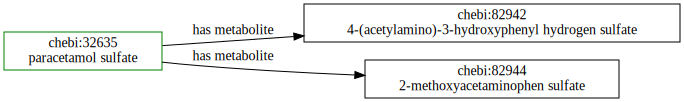

In [30]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='toMetabolite', transitive=False)

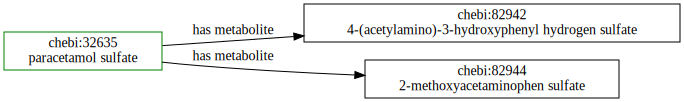

In [31]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='toMetabolite', transitive=True)

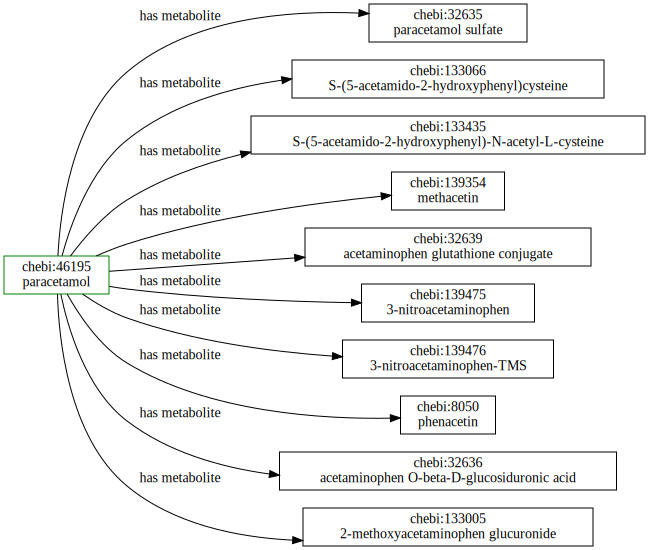

In [32]:
getMetaboliteGraph("chebidb:46195", highlightNodeColor="green", direction='toMetabolite', transitive=False)

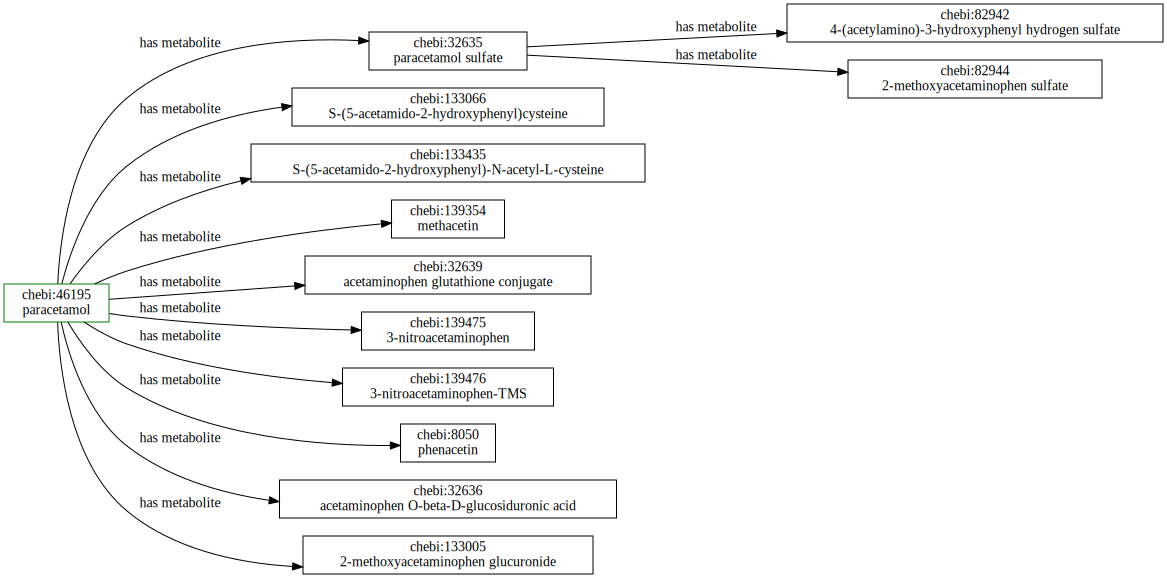

In [33]:
getMetaboliteGraph("chebidb:46195", highlightNodeColor="green", direction='toMetabolite', transitive=True)

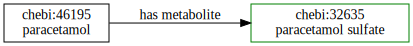

In [34]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='fromMetabolite', transitive=False, inferredMolecule=False, inferredFunctionalParent=False)

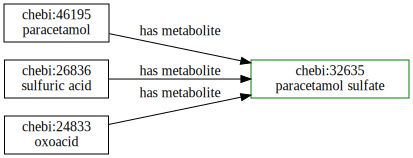

In [35]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='fromMetabolite', transitive=False, inferredMolecule=True, inferredFunctionalParent=False)

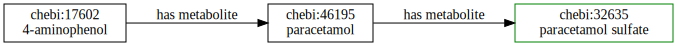

In [36]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='fromMetabolite', transitive=True, inferredMolecule=False, inferredFunctionalParent=False)

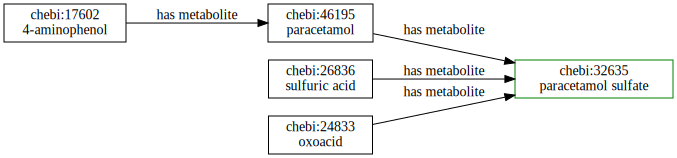

In [37]:
getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='fromMetabolite', transitive=True, inferredMolecule=True, inferredFunctionalParent=False)

In [38]:
testGraph = getMetaboliteGraph("chebidb:32635", highlightNodeColor="green", direction='fromMetabolite', transitive=True, inferredMolecule=True, inferredFunctionalParent=False)
highlightNode("chebidb:46195", highlightNodeColor="blue", graph=testGraph)

QueryBadFormed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL Update: No 'update=' parameter\n"